# 🎬 Action Recognition using CNN + LSTM

## UCF11 Dataset - Video Classification

This notebook implements a **CNN-LSTM** architecture for human action recognition on the UCF11 dataset.

### UCF11 Classes (11 actions):
basketball, biking, diving, golf_swing, horse_riding, soccer_juggling, swing, tennis_swing, trampoline_jumping, volleyball_spiking, walking

### Key Features:
- **Data Split**: 70% Training, 15% Validation, 15% Testing
- **Transfer Learning**: MobileNetV2 pretrained backbone
- **Early Stopping**: Saves best model based on validation loss
- **Comprehensive Evaluation**: Confusion Matrix, Classification Report, Per-class Accuracy

### Architecture Overview:
```
Input (frames) → MobileNetV2 Feature Extractor → LSTM Temporal Modeling → Dense Classifier → Action Label
```

---

In [1]:
# ============================================
# CELL 1: Import Required Libraries
# ============================================

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, LSTM, Dense, 
    TimeDistributed, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Input, Bidirectional,
    GRU, Activation, Add, LayerNormalization
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2026-01-04 16:46:55.875204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767545216.092401      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767545216.148953      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767545216.631246      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767545216.631301      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767545216.631304      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ============================================
# CELL 2: Configuration for UCF11 Dataset
# ============================================

class Config:
    """Configuration for UCF11 Action Recognition"""
    
    # Dataset paths - UCF11 dataset
    DATASET_PATH = "/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg"
    MODEL_SAVE_PATH = "/kaggle/working/best_action_recognition_model.keras"
    
    # Frame extraction
    NUM_FRAMES = 16          # Frames per video
    FRAME_HEIGHT = 112       # Resolution
    FRAME_WIDTH = 112
    CHANNELS = 3
    
    # Data split ratios
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # Training parameters
    BATCH_SIZE = 8
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    
    # Regularization
    DROPOUT_LSTM = 0.3
    DROPOUT_DENSE = 0.4
    
    # Early stopping
    PATIENCE = 10
    MIN_DELTA = 0.001
    
    # Random seed
    SEED = 42

config = Config()

print("=" * 50)
print("UCF11 CONFIGURATION")
print("=" * 50)
print(f"Dataset: UCF11 (11 action classes)")
print(f"Frame Size: {config.FRAME_HEIGHT}x{config.FRAME_WIDTH}")
print(f"Frames per Video: {config.NUM_FRAMES}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print("=" * 50)

UCF11 CONFIGURATION
Dataset: UCF11 (11 action classes)
Frame Size: 112x112
Frames per Video: 16
Batch Size: 8
Learning Rate: 0.001


📁 Dataset Path: /kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg
📊 Total Action Classes: 11

🏷️ Action Classes:
   1. basketball
   2. biking
   3. diving
   4. golf_swing
   5. horse_riding
   6. soccer_juggling
   7. swing
   8. tennis_swing
   9. trampoline_jumping
  10. volleyball_spiking
  11. walking

📹 Total Videos: 1600


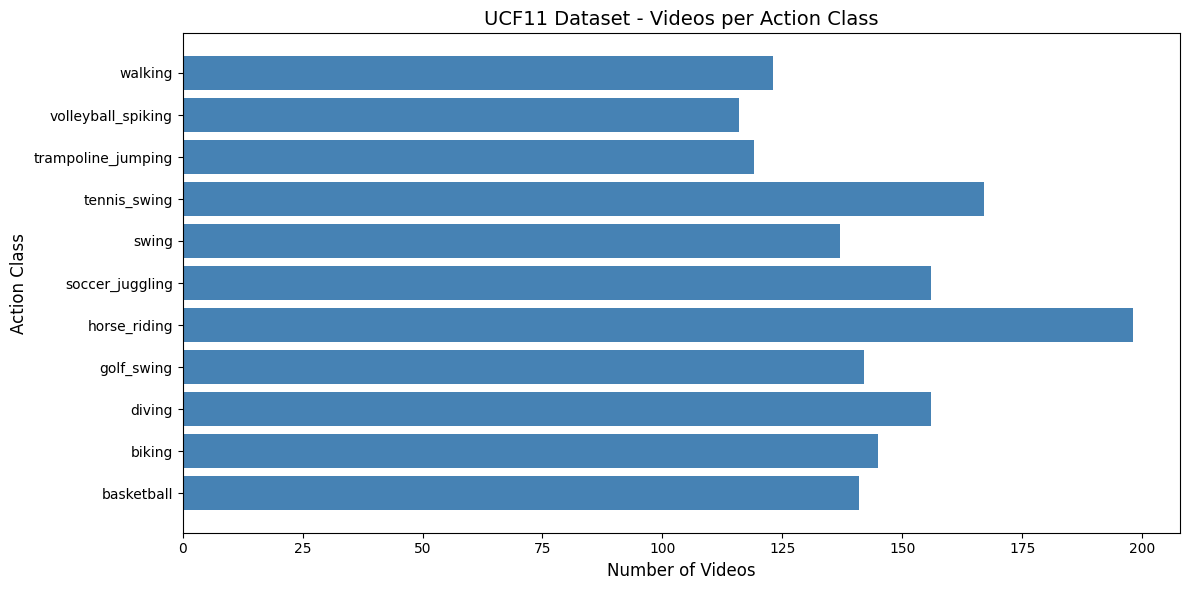

In [3]:
# ============================================
# CELL 3: Explore Dataset Structure
# ============================================

dataset_path = os.path.join(config.DATASET_PATH) 

# Get all action classes (subfolders inside UCF11)
all_classes = sorted([d for d in os.listdir(dataset_path) 
                      if os.path.isdir(os.path.join(dataset_path, d))])

print(f"📁 Dataset Path: {dataset_path}")
print(f"📊 Total Action Classes: {len(all_classes)}")
print("\n🏷️ Action Classes:")
for i, cls in enumerate(all_classes):
    print(f"  {i+1:2d}. {cls}")

# Count videos per class - UCF11 uses .mpg format
class_video_counts = {}
for cls in all_classes:
    class_path = os.path.join(dataset_path, cls)
    # Count all .mpg video files recursively (handles nested v_* folders)
    videos = glob(os.path.join(class_path, "**", "*.mpg"), recursive=True)
    if not videos:
        videos = glob(os.path.join(class_path, "*.mpg"))
    class_video_counts[cls] = len(videos)

print(f"\n📹 Total Videos: {sum(class_video_counts.values())}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.barh(list(class_video_counts.keys()), list(class_video_counts.values()), color='steelblue')
plt.xlabel('Number of Videos', fontsize=12)
plt.ylabel('Action Class', fontsize=12)
plt.title('UCF11 Dataset - Videos per Action Class', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
# ============================================
# CELL 4: Frame Extraction Functions
# ============================================

def extract_frames_uniform(video_path, num_frames=16, target_size=(112, 112)):
    """
    Extract frames uniformly sampled across the video.
    This ensures temporal coverage of the entire action.
    
    Args:
        video_path: Path to video file
        num_frames: Number of frames to extract
        target_size: (height, width) for resizing
    
    Returns:
        numpy array of shape (num_frames, height, width, 3)
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        # Read all frames and pad
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
        
        # Pad by repeating last frame
        while len(frames) < num_frames:
            if frames:
                frames.append(frames[-1].copy())
            else:
                cap.release()
                return None
    else:
        # Uniform sampling
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, target_size)
                frames.append(frame)
            else:
                # Fallback: use last valid frame
                if frames:
                    frames.append(frames[-1].copy())
    
    cap.release()
    
    if len(frames) != num_frames:
        return None
    
    return np.array(frames, dtype=np.float32)


print("✅ Frame extraction function defined")

✅ Frame extraction function defined


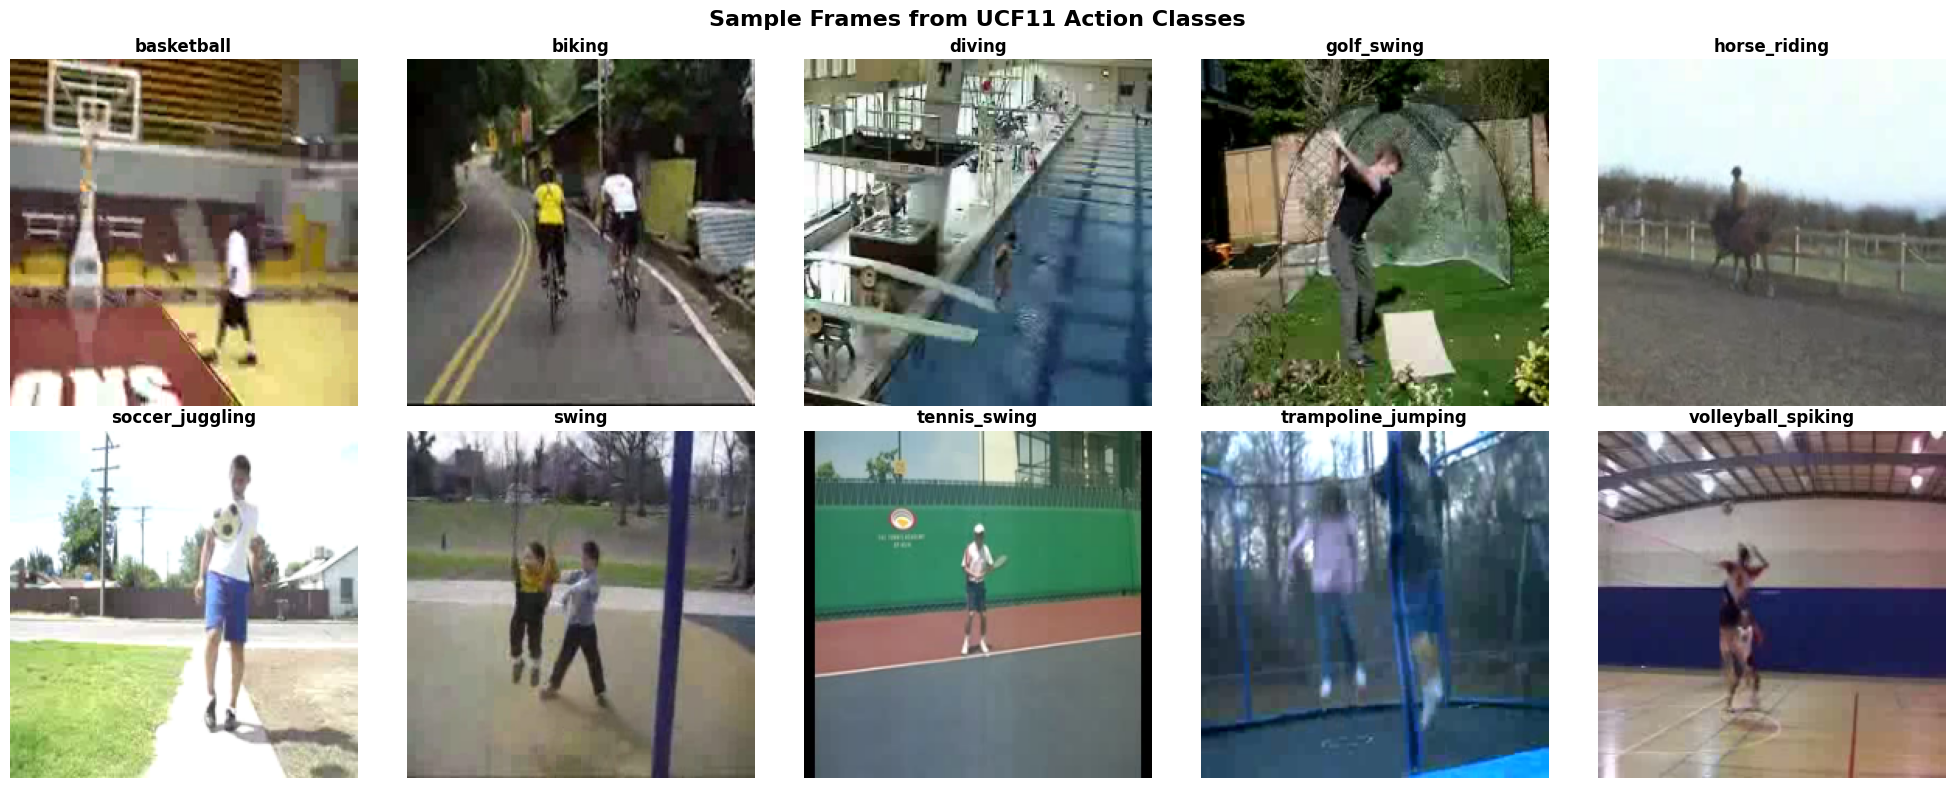

In [5]:
# ============================================
# CELL 5: Visualize Sample Frames from Each Class
# ============================================

def show_sample_frames(classes, dataset_path, num_samples=10):
    """Display sample frames from selected action classes"""
    
    n_classes = min(len(classes), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, cls in enumerate(classes[:n_classes]):
        class_path = os.path.join(dataset_path, cls)
        
        # Find video files - UCF11 uses .mpg format in nested v_* folders
        video_files = glob(os.path.join(class_path, "**", "*.mpg"), recursive=True)
        if not video_files:
            video_files = glob(os.path.join(class_path, "*.mpg"))
        
        if not video_files:
            axes[i].text(0.5, 0.5, f"No videos\n{cls}", ha='center', va='center')
            axes[i].axis('off')
            continue
        
        video_path = random.choice(video_files)
        
        cap = cv2.VideoCapture(video_path)
        # Read middle frame
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total // 2)
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            axes[i].imshow(frame)
            axes[i].set_title(cls, fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots if less than 10 classes
    for j in range(n_classes, 10):
        axes[j].axis('off')
    
    plt.suptitle("Sample Frames from UCF11 Action Classes", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show samples from first 10 classes (UCF11 has only 11)
show_sample_frames(all_classes, dataset_path)

In [6]:
# ============================================
# CELL 6: Load Dataset (LOAD MORE DATA)
# ============================================

def load_dataset(dataset_path, classes, num_frames, frame_size):
    """Load videos - UCF11 has fewer classes so we can load more videos"""
    X = []
    Y = []
    skipped = 0
    
    print("📥 Loading UCF11 dataset...")
    
    for class_idx, cls in enumerate(tqdm(classes, desc="Loading classes")):
        class_path = os.path.join(dataset_path, cls)
        
        # UCF11 uses .mpg format with nested v_* folders
        video_files = glob(os.path.join(class_path, "**", "*.mpg"), recursive=True)
        if not video_files:
            video_files = glob(os.path.join(class_path, "*.mpg"))
        
        # UCF11 has ~145 videos per class, load up to 100 for good coverage
        video_files = video_files[:100]
        
        for video_path in video_files:
            frames = extract_frames_uniform(
                video_path, 
                num_frames=num_frames, 
                target_size=frame_size
            )
            if frames is not None and frames.shape == (num_frames, *frame_size, 3):
                X.append(frames)
                Y.append(class_idx)
            else:
                skipped += 1
    
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.int32)
    
    print(f"\n✅ UCF11 Dataset loaded!")
    print(f"   Total samples: {len(X)}")
    print(f"   Skipped: {skipped}")
    print(f"   X shape: {X.shape}")
    
    return X, Y, classes

# Load the dataset
X, Y, class_names = load_dataset(
    config.DATASET_PATH,
    all_classes,
    config.NUM_FRAMES,
    (config.FRAME_HEIGHT, config.FRAME_WIDTH)
)

num_classes = len(class_names)
print(f"\n📊 Number of classes: {num_classes}")

📥 Loading UCF11 dataset...


Loading classes: 100%|██████████| 11/11 [00:51<00:00,  4.72s/it]



✅ UCF11 Dataset loaded!
   Total samples: 1100
   Skipped: 0
   X shape: (1100, 16, 112, 112, 3)

📊 Number of classes: 11


In [7]:
# ============================================
# CELL 7: Train/Validation/Test Split (70/10/20)
# ============================================

# Normalize data to [0, 1]
X_normalized = X / 255.0

# First split: 70% train, 30% temp (for val + test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_normalized, Y,
    test_size=(config.VAL_RATIO + config.TEST_RATIO),  # 30%
    random_state=config.SEED,
    stratify=Y
)

# Second split: Split temp into val and test (50-50 of 30% = 15% each)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp,
    test_size=0.5,  # 50% of 30% = 15%
    random_state=config.SEED,
    stratify=Y_temp
)

# Convert labels to one-hot encoding
Y_train_cat = to_categorical(Y_train, num_classes)
Y_val_cat = to_categorical(Y_val, num_classes)
Y_test_cat = to_categorical(Y_test, num_classes)

print("=" * 60)
print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Training set:   {X_train.shape[0]:5d} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:5d} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:5d} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print("=" * 60)
print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"\nY_train shape: {Y_train_cat.shape}")
print(f"Y_val shape:   {Y_val_cat.shape}")
print(f"Y_test shape:  {Y_test_cat.shape}")

# Verify class distribution
print("\n📊 Class distribution in splits:")
for name, labels in [("Train", Y_train), ("Val", Y_val), ("Test", Y_test)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {name}: min={counts.min()}, max={counts.max()}, mean={counts.mean():.1f}")

DATA SPLIT SUMMARY
Training set:     770 samples (70.0%)
Validation set:   165 samples (15.0%)
Test set:         165 samples (15.0%)

X_train shape: (770, 16, 112, 112, 3)
X_val shape:   (165, 16, 112, 112, 3)
X_test shape:  (165, 16, 112, 112, 3)

Y_train shape: (770, 11)
Y_val shape:   (165, 11)
Y_test shape:  (165, 11)

📊 Class distribution in splits:
  Train: min=70, max=70, mean=70.0
  Val: min=15, max=15, mean=15.0
  Test: min=15, max=15, mean=15.0


📊 Class Weights (for handling imbalance):
----------------------------------------
  basketball          : 1.0000
  biking              : 1.0000
  diving              : 1.0000
  golf_swing          : 1.0000
  horse_riding        : 1.0000
  soccer_juggling     : 1.0000
  swing               : 1.0000
  tennis_swing        : 1.0000
  trampoline_jumping  : 1.0000
  volleyball_spiking  : 1.0000
  ... and 1 more classes


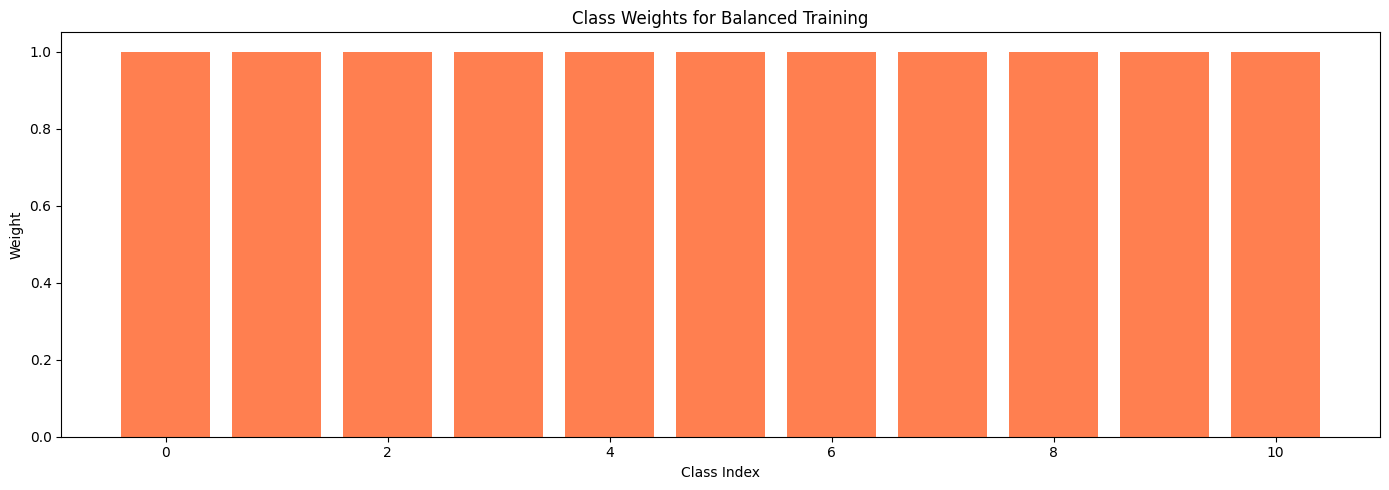

In [8]:
# ============================================
# CELL 8: Compute Class Weights (Handle Imbalance)
# ============================================

class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights_values))

print("📊 Class Weights (for handling imbalance):")
print("-" * 40)
for i, (cls_name, weight) in enumerate(zip(class_names[:10], list(class_weights.values())[:10])):
    print(f"  {cls_name:20s}: {weight:.4f}")
if len(class_names) > 10:
    print(f"  ... and {len(class_names) - 10} more classes")

# Visualize class weights
plt.figure(figsize=(14, 5))
plt.bar(range(num_classes), list(class_weights.values()), color='coral')
plt.xlabel('Class Index')
plt.ylabel('Weight')
plt.title('Class Weights for Balanced Training')
plt.tight_layout()
plt.show()

In [9]:
# ============================================
# CELL 9: BUILD IMPROVED MODEL WITH TRANSFER LEARNING
# ============================================

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_transfer_learning_model(input_shape, num_classes, config):
    """
    IMPROVED CNN-LSTM with Transfer Learning using MobileNetV2.
    MobileNetV2 is pretrained on ImageNet - gives much better features!
    """
    
    # Load pretrained MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[1], input_shape[2], input_shape[3])
    )
    
    # Freeze early layers, train later layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    # Build the model
    model = Sequential(name="ActionRecognition_TransferLearning")
    
    # TimeDistributed MobileNetV2 feature extractor
    model.add(TimeDistributed(base_model, input_shape=input_shape))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    # LSTM for temporal modeling
    model.add(LSTM(256, return_sequences=True, dropout=0.2))
    model.add(LSTM(128, return_sequences=False, dropout=0.2))
    model.add(Dropout(config.DROPOUT_LSTM))
    
    # Classification head
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(config.DROPOUT_DENSE))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(config.DROPOUT_DENSE))
    
    # Output
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


# Build model
input_shape = (config.NUM_FRAMES, config.FRAME_HEIGHT, config.FRAME_WIDTH, config.CHANNELS)
model = build_transfer_learning_model(input_shape, num_classes, config)

# Compile with Adam
optimizer = Adam(learning_rate=config.LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "=" * 70)
print("IMPROVED MODEL WITH TRANSFER LEARNING (MobileNetV2)")
print("=" * 70)
model.summary()

# Count parameters
trainable = sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable = sum([np.prod(v.shape) for v in model.non_trainable_weights])
print(f"\n📊 Total parameters: {trainable + non_trainable:,}")
print(f"   Trainable: {trainable:,}")
print(f"   Non-trainable (frozen): {non_trainable:,}")

/tmp/ipykernel_55/844905799.py:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
I0000 00:00:1767545293.829293      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



IMPROVED MODEL WITH TRANSFER LEARNING (MobileNetV2)


Model: "ActionRecognition_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 256)        │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097,355 (15.63 MB)

 Trainable params: 3,365,259 (12.84 MB)

 Non-trainable params: 732,096 (2.79 MB)


📊 Total parameters: 4,097,355
   Trainable: 3,365,259
   Non-trainable (frozen): 732,096


In [10]:
# ============================================
# CELL 10: Define Callbacks (Early Stopping, Checkpointing, LR Scheduler)
# ============================================

# Create directory for saving model
os.makedirs('/kaggle/working', exist_ok=True)

# 1. Early Stopping - Stop when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=config.PATIENCE,
    min_delta=config.MIN_DELTA,
    verbose=1,
    mode='min',
    restore_best_weights=True  # Restore best weights at the end
)

# 2. Model Checkpoint - Save best model
model_checkpoint = ModelCheckpoint(
    filepath=config.MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# 3. Learning Rate Scheduler - Reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # Reduce LR by half
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, lr_scheduler]

print("✅ Callbacks configured:")
print(f"   - EarlyStopping: patience={config.PATIENCE}, monitor='val_loss'")
print(f"   - ModelCheckpoint: saving best model to '{config.MODEL_SAVE_PATH}'")
print(f"   - ReduceLROnPlateau: factor=0.5, patience=5")

✅ Callbacks configured:
   - EarlyStopping: patience=10, monitor='val_loss'
   - ModelCheckpoint: saving best model to '/kaggle/working/best_action_recognition_model.keras'
   - ReduceLROnPlateau: factor=0.5, patience=5


In [11]:
# ============================================
# CELL 11: Train the Model
# ============================================

print("=" * 70)
print("🚀 STARTING MODEL TRAINING")
print("=" * 70)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Max epochs: {config.EPOCHS}")
print("=" * 70)

history = model.fit(
    X_train, Y_train_cat,
    validation_data=(X_val, Y_val_cat),
    epochs=config.EPOCHS,
    batch_size=config.BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "=" * 70)
print("✅ TRAINING COMPLETED")
print("=" * 70)
print(f"Total epochs run: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

🚀 STARTING MODEL TRAINING
Training samples: 770
Validation samples: 165
Batch size: 8
Max epochs: 50
Epoch 1/50


I0000 00:00:1767545383.685526    3459 cuda_dnn.cc:529] Loaded cuDNN version 91002


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.0995 - loss: 3.0464
Epoch 1: val_loss improved from inf to 2.10626, saving model to /kaggle/working/best_action_recognition_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 127s 428ms/step - accuracy: 0.0998 - loss: 3.0446 - val_accuracy: 0.3333 - val_loss: 2.1063 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2343 - loss: 2.3379
Epoch 2: val_loss improved from 2.10626 to 1.95928, saving model to /kaggle/working/best_action_recognition_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.2346 - loss: 2.3375 - val_accuracy: 0.3515 - val_loss: 1.9593 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2790 - loss: 2.2752
Epoch 3: val_loss improved from 1.95928 to 1.64485, saving model to /kaggle/working/best_action_recognition_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.2791 - loss: 2.2751 - val_accuracy: 0.4303 - val_loss: 1

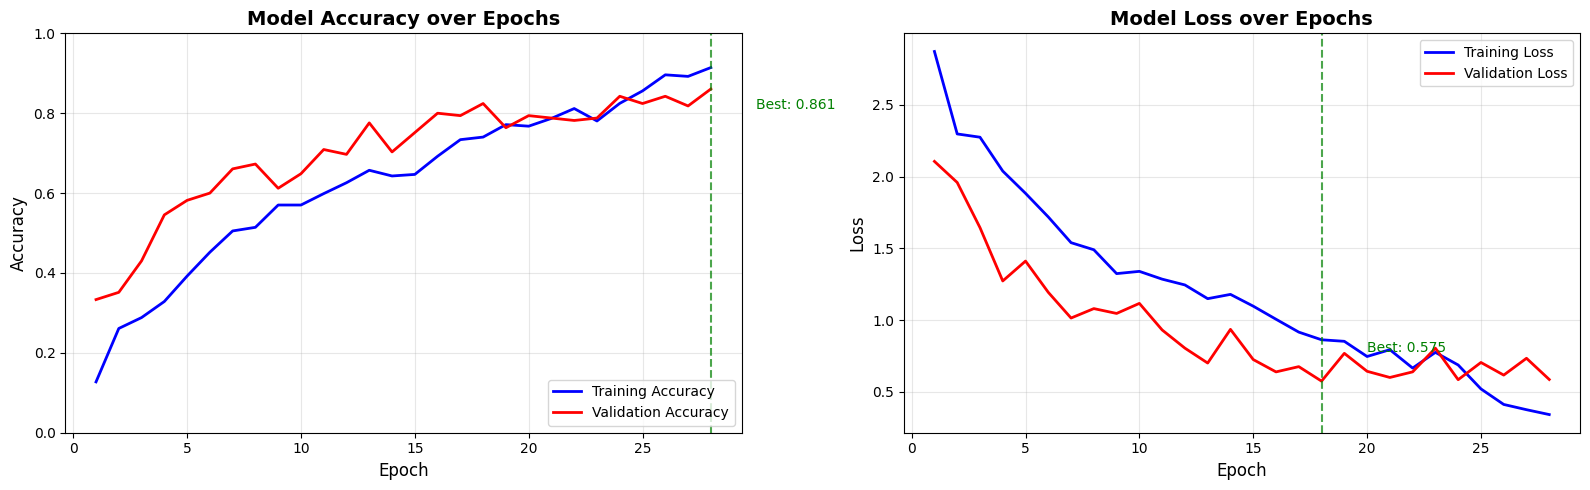


📊 Training Analysis:
   Final Training Accuracy: 0.9143
   Final Validation Accuracy: 0.8606
   Gap (potential overfitting indicator): 0.0537
   ℹ️  Moderate gap - acceptable


In [12]:
# ============================================
# CELL 12: Plot Training History (Loss & Accuracy)
# ============================================

def plot_training_history(history):
    """Plot training and validation accuracy/loss curves"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Plot Accuracy
    axes[0].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Mark best validation accuracy
    best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    axes[0].axvline(x=best_val_acc_epoch, color='g', linestyle='--', alpha=0.7)
    axes[0].annotate(f'Best: {best_val_acc:.3f}', 
                     xy=(best_val_acc_epoch, best_val_acc),
                     xytext=(best_val_acc_epoch + 2, best_val_acc - 0.05),
                     fontsize=10, color='green')
    
    # Plot Loss
    axes[1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss over Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Mark best validation loss
    best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = min(history.history['val_loss'])
    axes[1].axvline(x=best_val_loss_epoch, color='g', linestyle='--', alpha=0.7)
    axes[1].annotate(f'Best: {best_val_loss:.3f}', 
                     xy=(best_val_loss_epoch, best_val_loss),
                     xytext=(best_val_loss_epoch + 2, best_val_loss + 0.2),
                     fontsize=10, color='green')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Check for overfitting
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    
    print("\n📊 Training Analysis:")
    print(f"   Final Training Accuracy: {final_train_acc:.4f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"   Gap (potential overfitting indicator): {gap:.4f}")
    
    if gap > 0.15:
        print("   ⚠️  Significant gap detected - some overfitting may be present")
    elif gap < 0.05:
        print("   ✅ Small gap - good generalization!")
    else:
        print("   ℹ️  Moderate gap - acceptable")

plot_training_history(history)

In [13]:
# ============================================
# CELL 13: Evaluate on All Sets (Train, Validation, Test)
# ============================================

print("=" * 70)
print("📊 MODEL EVALUATION ON ALL DATASETS")
print("=" * 70)

# Load best model
from tensorflow.keras.models import load_model
best_model = load_model(config.MODEL_SAVE_PATH)
print(f"✅ Loaded best model from: {config.MODEL_SAVE_PATH}")

# Evaluate on Training set
train_loss, train_acc = best_model.evaluate(X_train, Y_train_cat, verbose=0)
print(f"\n🔵 TRAINING SET:")
print(f"   Loss: {train_loss:.4f}")
print(f"   Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")

# Evaluate on Validation set
val_loss, val_acc = best_model.evaluate(X_val, Y_val_cat, verbose=0)
print(f"\n🟡 VALIDATION SET:")
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

# Evaluate on Test set
test_loss, test_acc = best_model.evaluate(X_test, Y_test_cat, verbose=0)
print(f"\n🟢 TEST SET:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"{'Dataset':<15} {'Accuracy':>10} {'Loss':>10}")
print("-" * 35)
print(f"{'Training':<15} {train_acc:>10.4f} {train_loss:>10.4f}")
print(f"{'Validation':<15} {val_acc:>10.4f} {val_loss:>10.4f}")
print(f"{'Test':<15} {test_acc:>10.4f} {test_loss:>10.4f}")
print("=" * 70)

# Check for generalization
train_val_gap = train_acc - val_acc
train_test_gap = train_acc - test_acc

print("\n📈 Generalization Analysis:")
if train_val_gap < 0.10 and train_test_gap < 0.10:
    print("   ✅ Excellent generalization - model performs well on unseen data!")
elif train_val_gap < 0.15 and train_test_gap < 0.15:
    print("   ℹ️  Good generalization with minor variance")
else:
    print("   ⚠️  Some overfitting detected - consider more regularization")

📊 MODEL EVALUATION ON ALL DATASETS
✅ Loaded best model from: /kaggle/working/best_action_recognition_model.keras

🔵 TRAINING SET:
   Loss: 0.3690
   Accuracy: 0.8688 (86.88%)

🟡 VALIDATION SET:
   Loss: 0.5751
   Accuracy: 0.8242 (82.42%)

🟢 TEST SET:
   Loss: 0.6613
   Accuracy: 0.8000 (80.00%)

SUMMARY
Dataset           Accuracy       Loss
-----------------------------------
Training            0.8688     0.3690
Validation          0.8242     0.5751
Test                0.8000     0.6613

📈 Generalization Analysis:
   ✅ Excellent generalization - model performs well on unseen data!


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step 


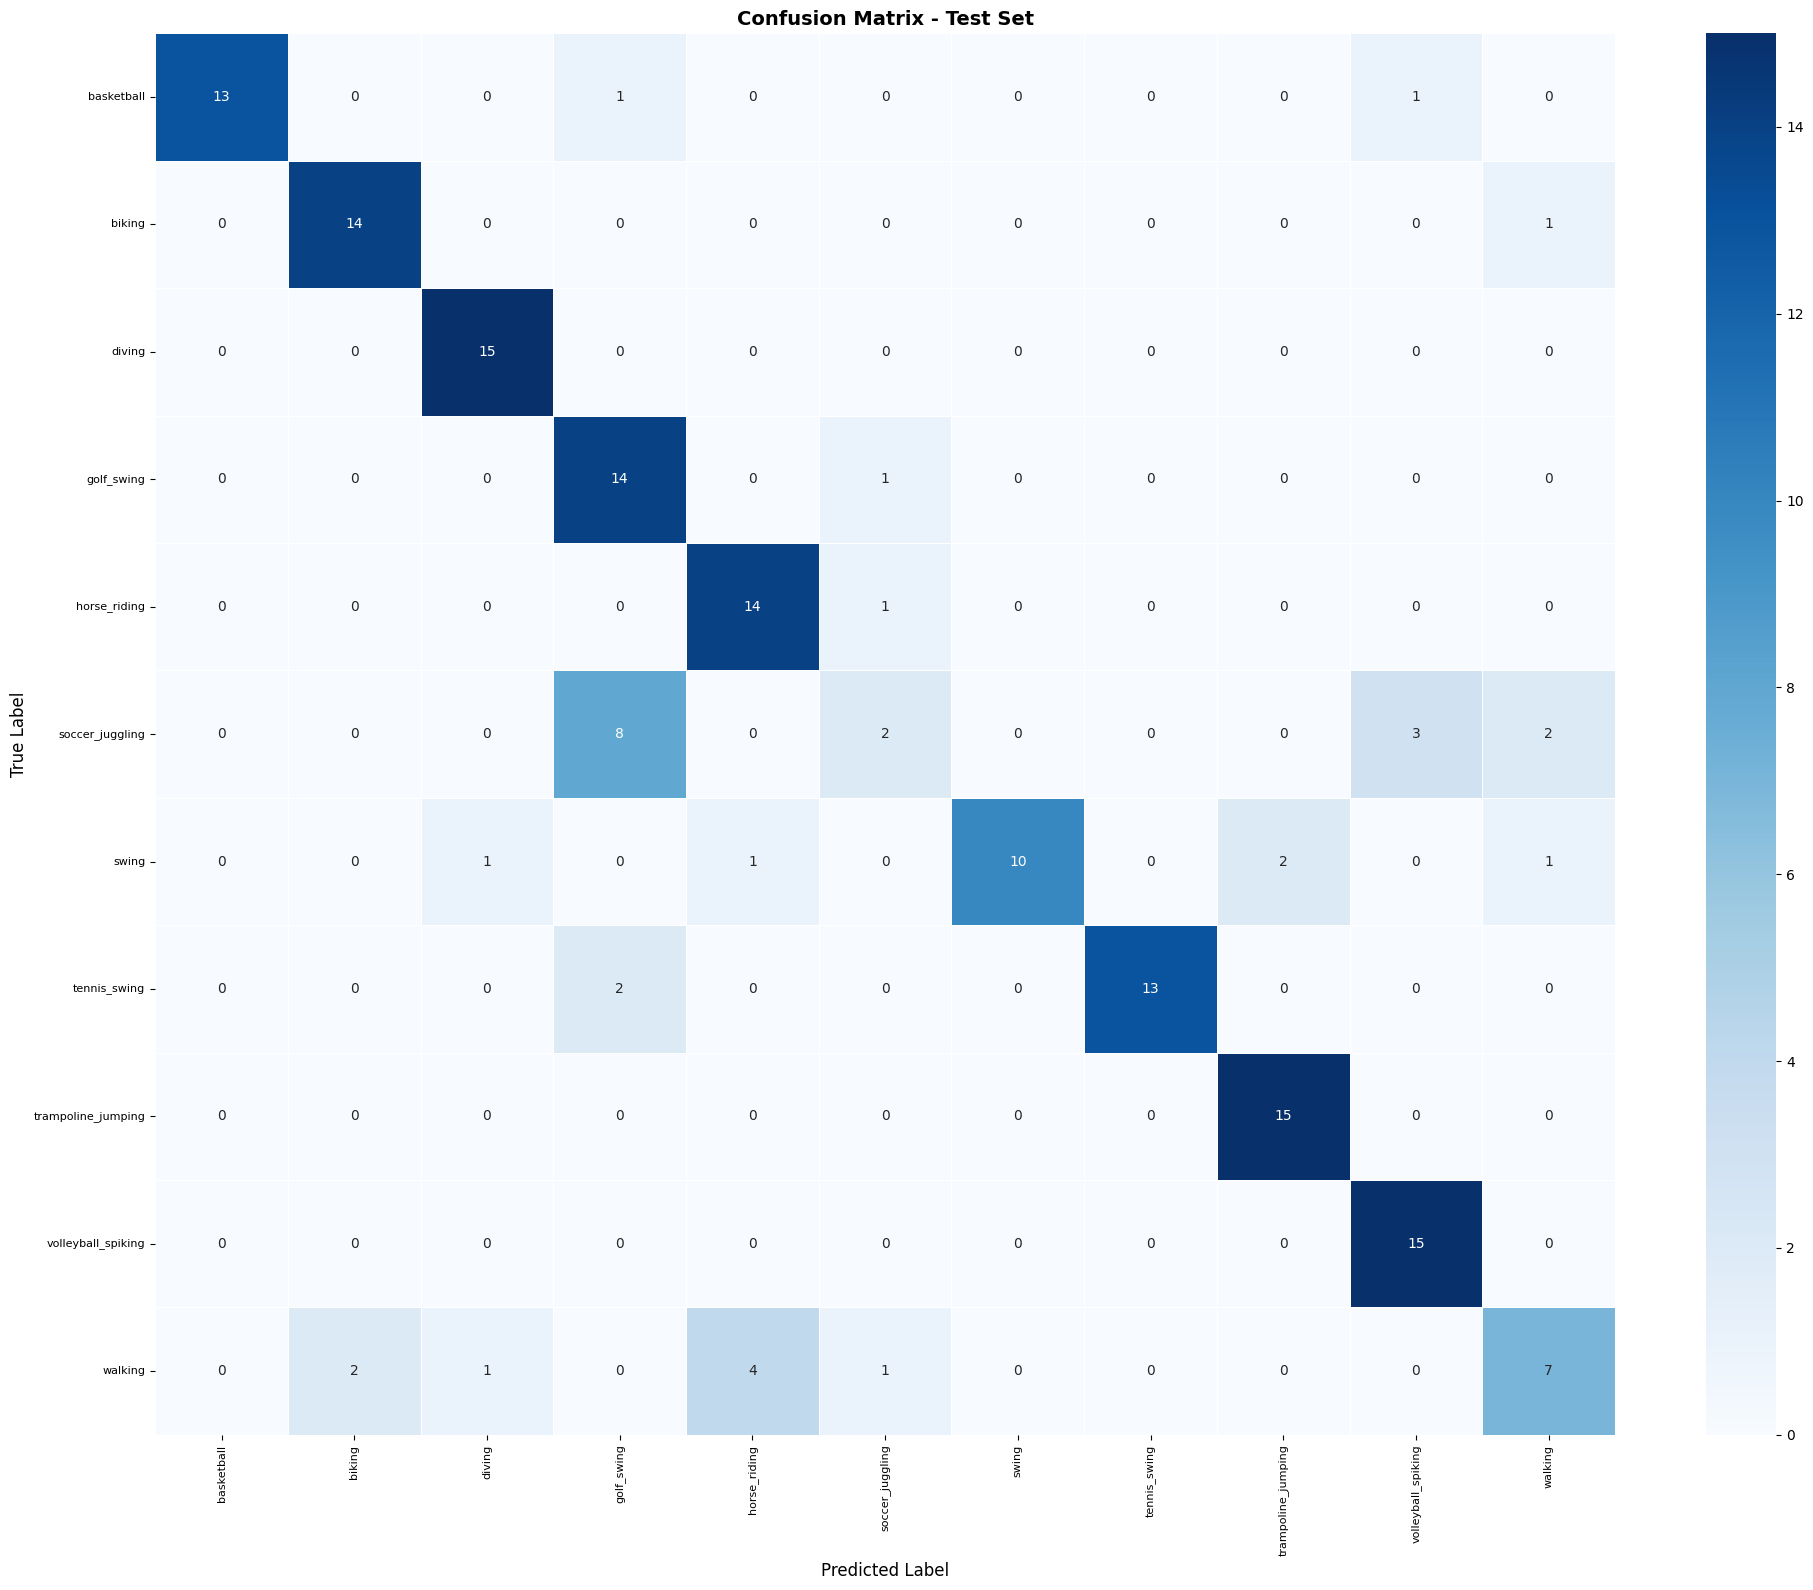

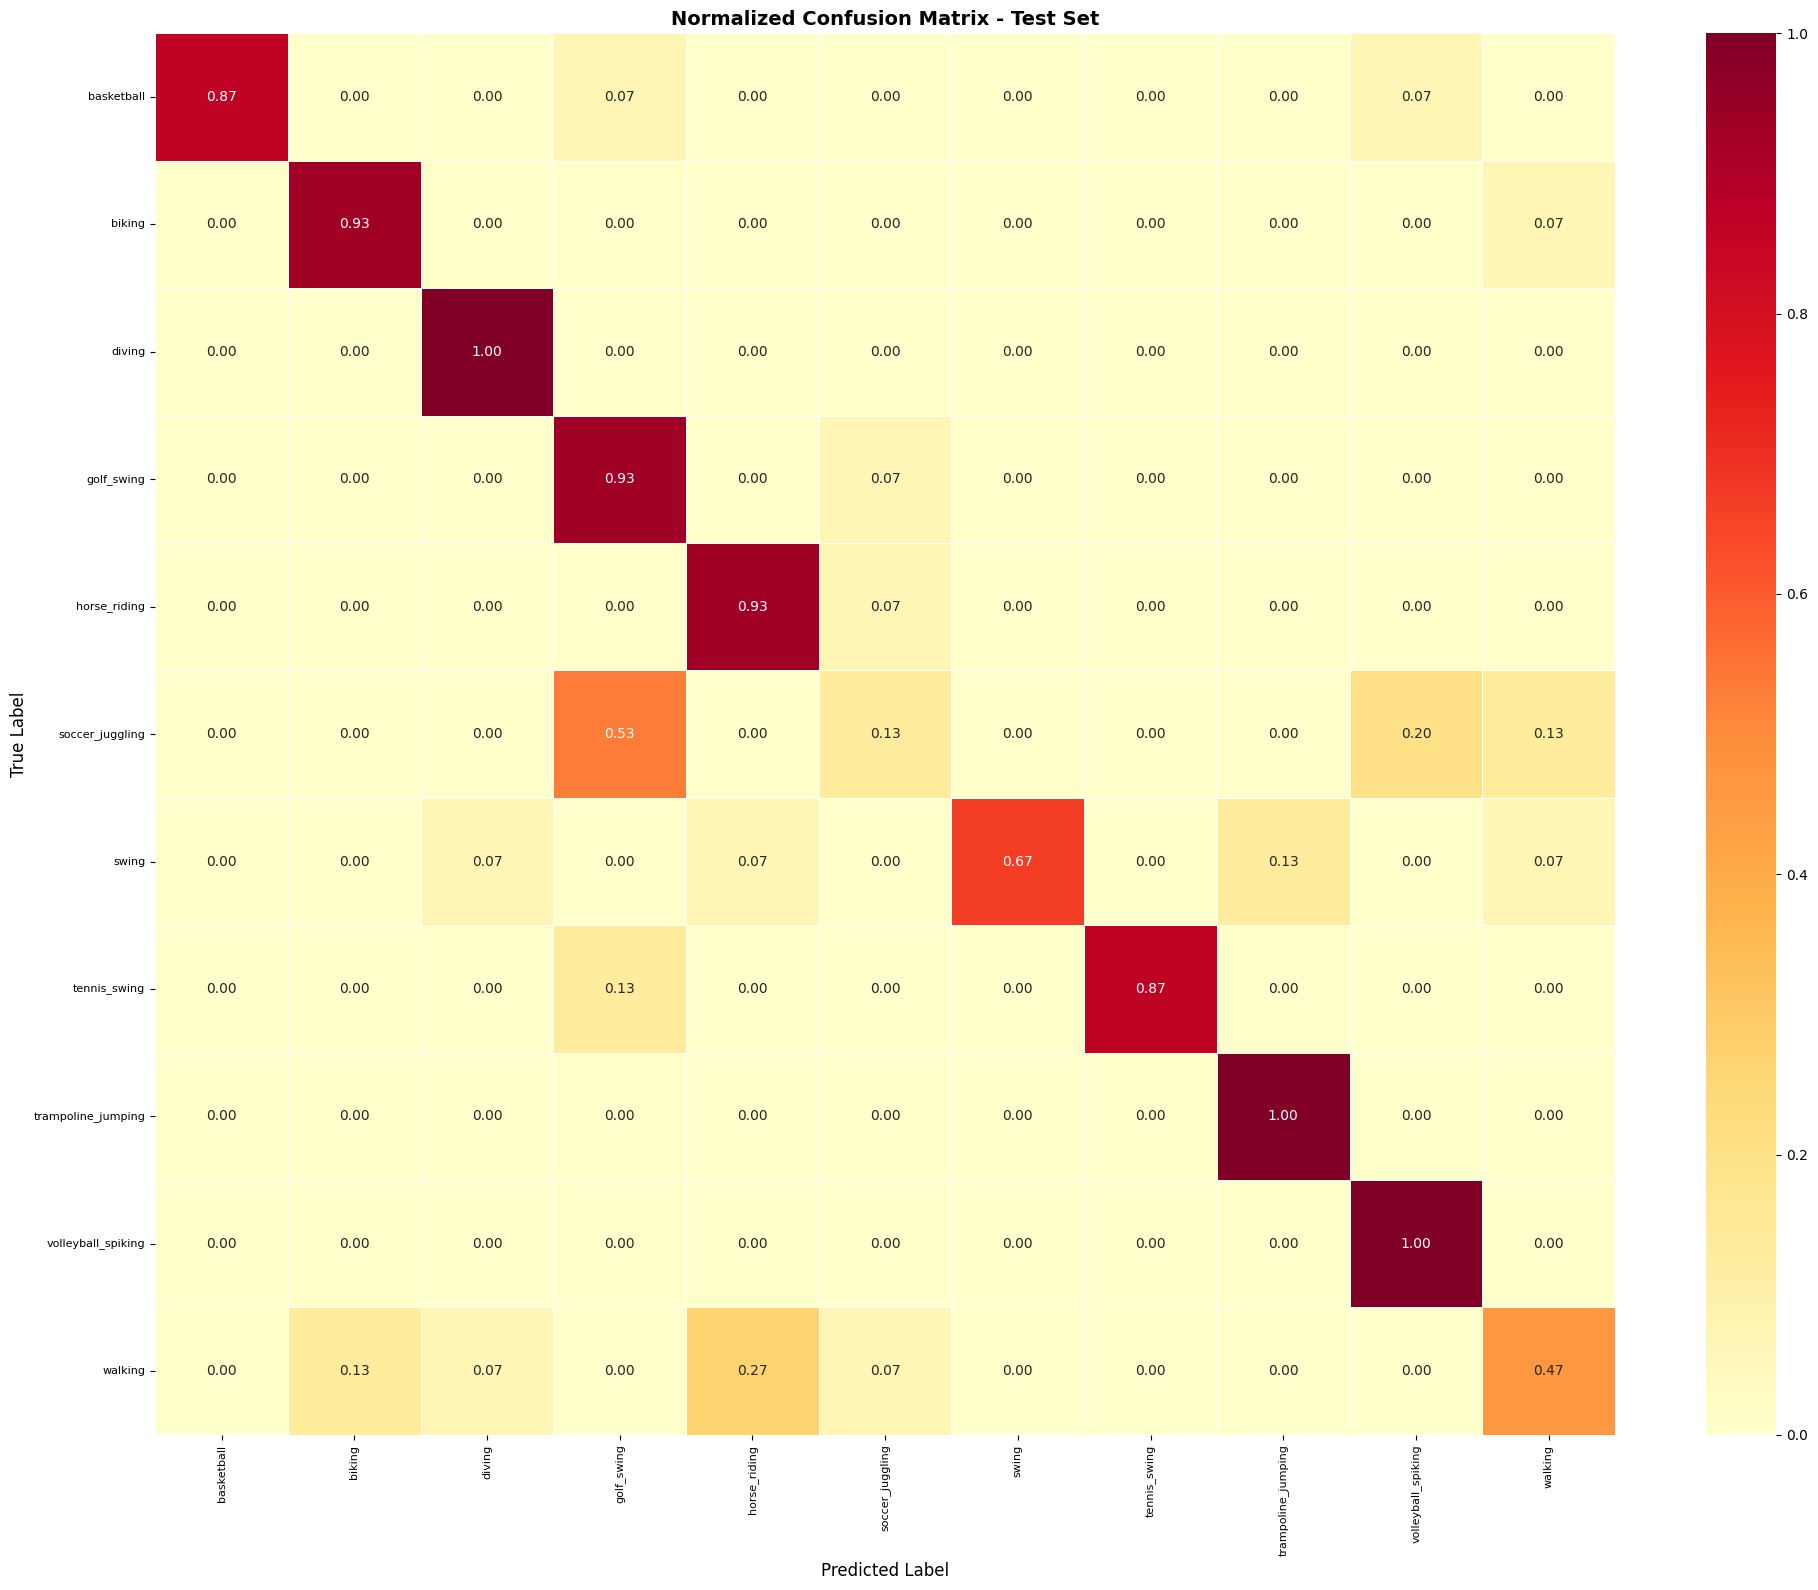

In [14]:
# ============================================
# CELL 14: Confusion Matrix
# ============================================

# Get predictions
Y_pred_probs = best_model.predict(X_test, verbose=1)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = Y_test

# Create confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 16))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='YlOrRd',
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    vmin=0, 
    vmax=1
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

CLASSIFICATION REPORT - TEST SET
                    precision    recall  f1-score   support

        basketball     1.0000    0.8667    0.9286        15
            biking     0.8750    0.9333    0.9032        15
            diving     0.8824    1.0000    0.9375        15
        golf_swing     0.5600    0.9333    0.7000        15
      horse_riding     0.7368    0.9333    0.8235        15
   soccer_juggling     0.4000    0.1333    0.2000        15
             swing     1.0000    0.6667    0.8000        15
      tennis_swing     1.0000    0.8667    0.9286        15
trampoline_jumping     0.8824    1.0000    0.9375        15
volleyball_spiking     0.7895    1.0000    0.8824        15
           walking     0.6364    0.4667    0.5385        15

          accuracy                         0.8000       165
         macro avg     0.7966    0.8000    0.7800       165
      weighted avg     0.7966    0.8000    0.7800       165


📊 Per-Class Accuracy (sorted by performance):
             Clas

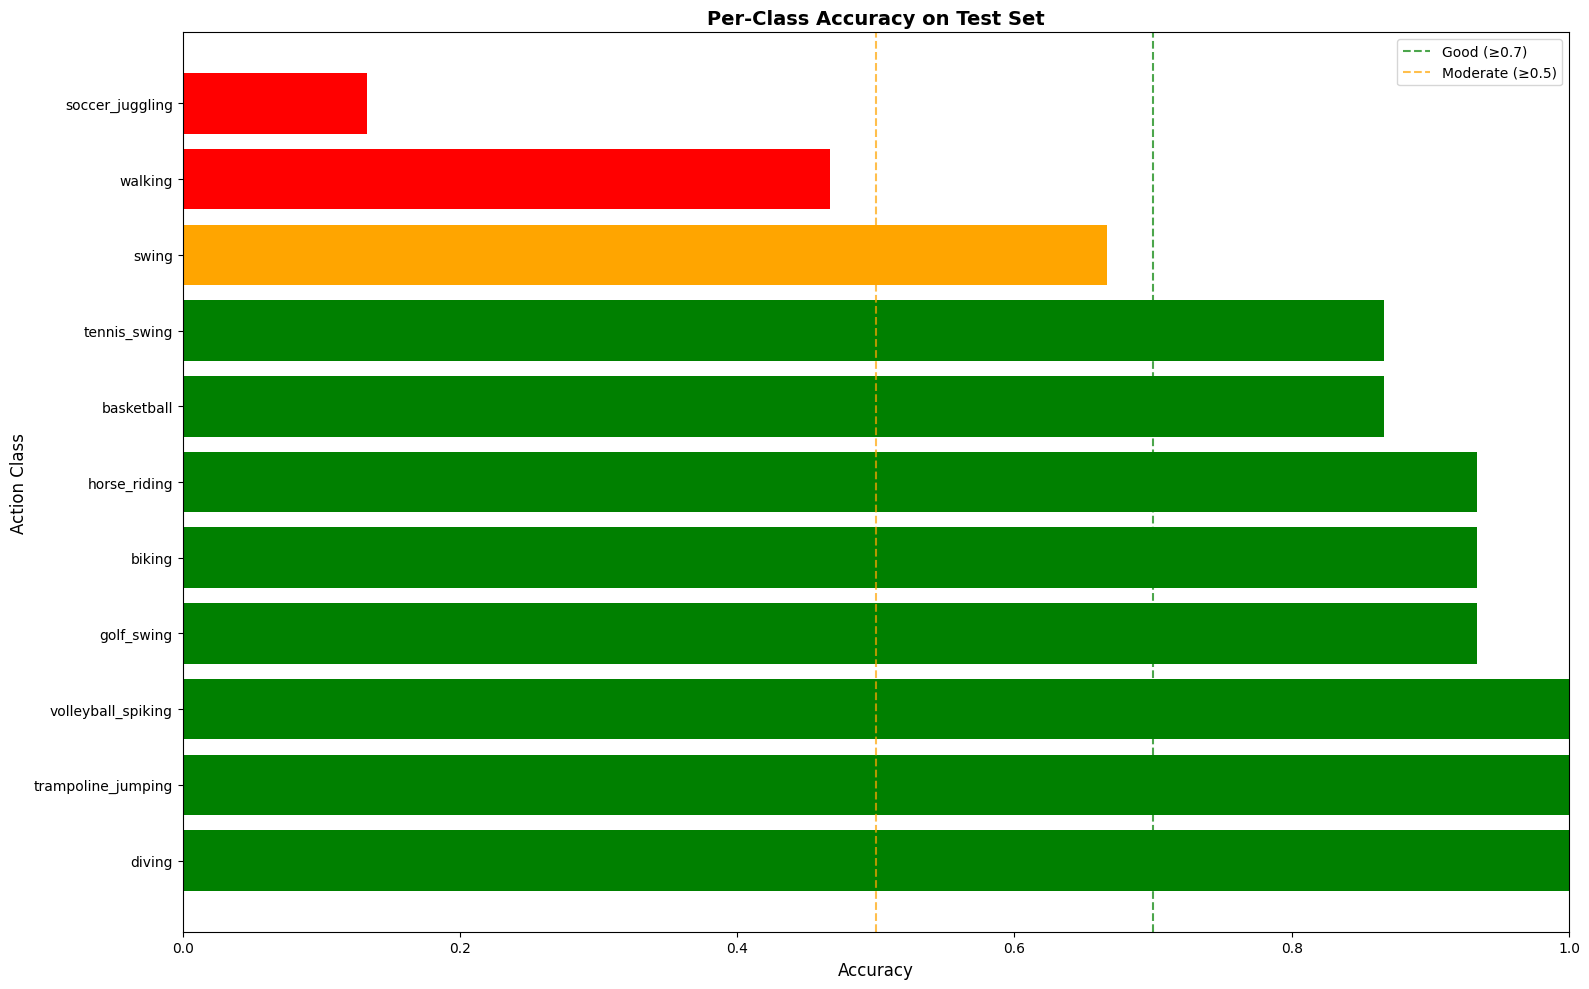


🏆 Top 5 Best Performing Classes:
   diving                   : 1.0000
   trampoline_jumping       : 1.0000
   volleyball_spiking       : 1.0000
   golf_swing               : 0.9333
   biking                   : 0.9333

⚠️  Top 5 Worst Performing Classes:
   basketball               : 0.8667
   tennis_swing             : 0.8667
   swing                    : 0.6667
   walking                  : 0.4667
   soccer_juggling          : 0.1333


In [15]:
# ============================================
# CELL 15: Classification Report & Per-Class Metrics
# ============================================

# Generate classification report
print("=" * 80)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 80)
report = classification_report(Y_true, Y_pred, target_names=class_names, digits=4)
print(report)

# Save classification report
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write("CLASSIFICATION REPORT - TEST SET\n")
    f.write("=" * 80 + "\n")
    f.write(report)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Create DataFrame for per-class metrics
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': per_class_accuracy,
    'Support': cm.sum(axis=1)
})
metrics_df = metrics_df.sort_values('Accuracy', ascending=False)

print("\n📊 Per-Class Accuracy (sorted by performance):")
print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_csv('/kaggle/working/per_class_metrics.csv', index=False)

# Visualize per-class accuracy
plt.figure(figsize=(16, 10))
colors = ['green' if acc >= 0.7 else 'orange' if acc >= 0.5 else 'red' for acc in metrics_df['Accuracy']]
plt.barh(metrics_df['Class'], metrics_df['Accuracy'], color=colors)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Action Class', fontsize=12)
plt.title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
plt.axvline(x=0.7, color='green', linestyle='--', alpha=0.7, label='Good (≥0.7)')
plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Moderate (≥0.5)')
plt.legend()
plt.xlim([0, 1])
plt.tight_layout()
plt.savefig('/kaggle/working/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify best and worst performing classes
print("\n🏆 Top 5 Best Performing Classes:")
for i, row in metrics_df.head(5).iterrows():
    print(f"   {row['Class']:25s}: {row['Accuracy']:.4f}")

print("\n⚠️  Top 5 Worst Performing Classes:")
for i, row in metrics_df.tail(5).iterrows():
    print(f"   {row['Class']:25s}: {row['Accuracy']:.4f}")

OVERALL METRICS - TEST SET

Metric                           Macro     Weighted
--------------------------------------------------
Precision                       0.7966       0.7966
Recall                          0.8000       0.8000
F1-Score                        0.7800       0.7800

Overall Accuracy                0.8000


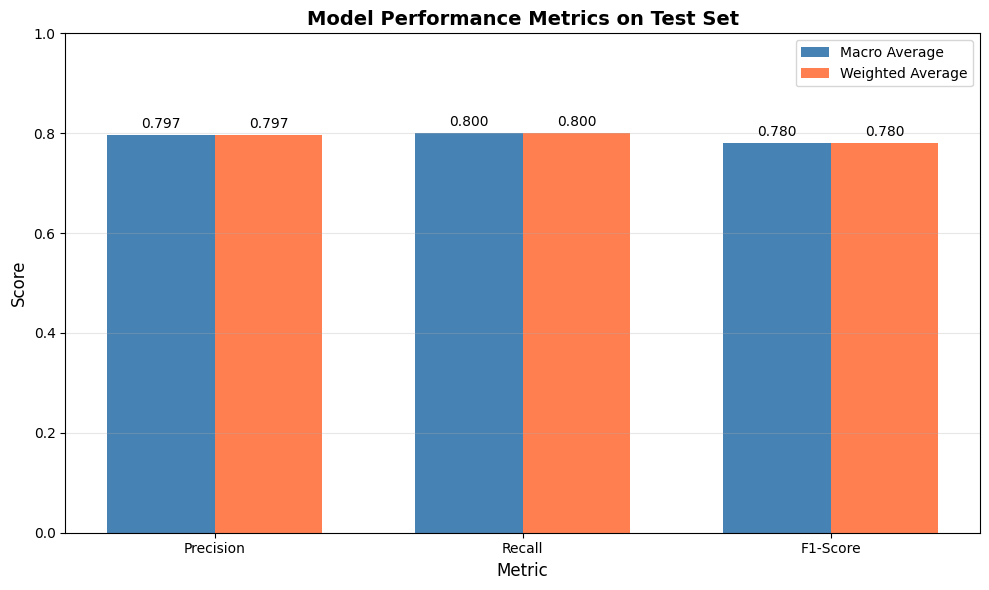

In [16]:
# ============================================
# CELL 16: Additional Metrics (Precision, Recall, F1-Score)
# ============================================

# Calculate overall metrics
precision_macro = precision_score(Y_true, Y_pred, average='macro')
precision_weighted = precision_score(Y_true, Y_pred, average='weighted')
recall_macro = recall_score(Y_true, Y_pred, average='macro')
recall_weighted = recall_score(Y_true, Y_pred, average='weighted')
f1_macro = f1_score(Y_true, Y_pred, average='macro')
f1_weighted = f1_score(Y_true, Y_pred, average='weighted')
overall_accuracy = accuracy_score(Y_true, Y_pred)

print("=" * 60)
print("OVERALL METRICS - TEST SET")
print("=" * 60)
print(f"\n{'Metric':<25} {'Macro':>12} {'Weighted':>12}")
print("-" * 50)
print(f"{'Precision':<25} {precision_macro:>12.4f} {precision_weighted:>12.4f}")
print(f"{'Recall':<25} {recall_macro:>12.4f} {recall_weighted:>12.4f}")
print(f"{'F1-Score':<25} {f1_macro:>12.4f} {f1_weighted:>12.4f}")
print(f"\n{'Overall Accuracy':<25} {overall_accuracy:>12.4f}")
print("=" * 60)

# Create metrics comparison visualization
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Macro': [precision_macro, recall_macro, f1_macro],
    'Weighted': [precision_weighted, recall_weighted, f1_weighted]
}
metrics_compare_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_compare_df['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_compare_df['Macro'], width, label='Macro Average', color='steelblue')
bars2 = ax.bar(x + width/2, metrics_compare_df['Weighted'], width, label='Weighted Average', color='coral')

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics on Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_compare_df['Metric'])
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

🧪 TESTING ON RANDOM SAMPLES FROM TEST SET


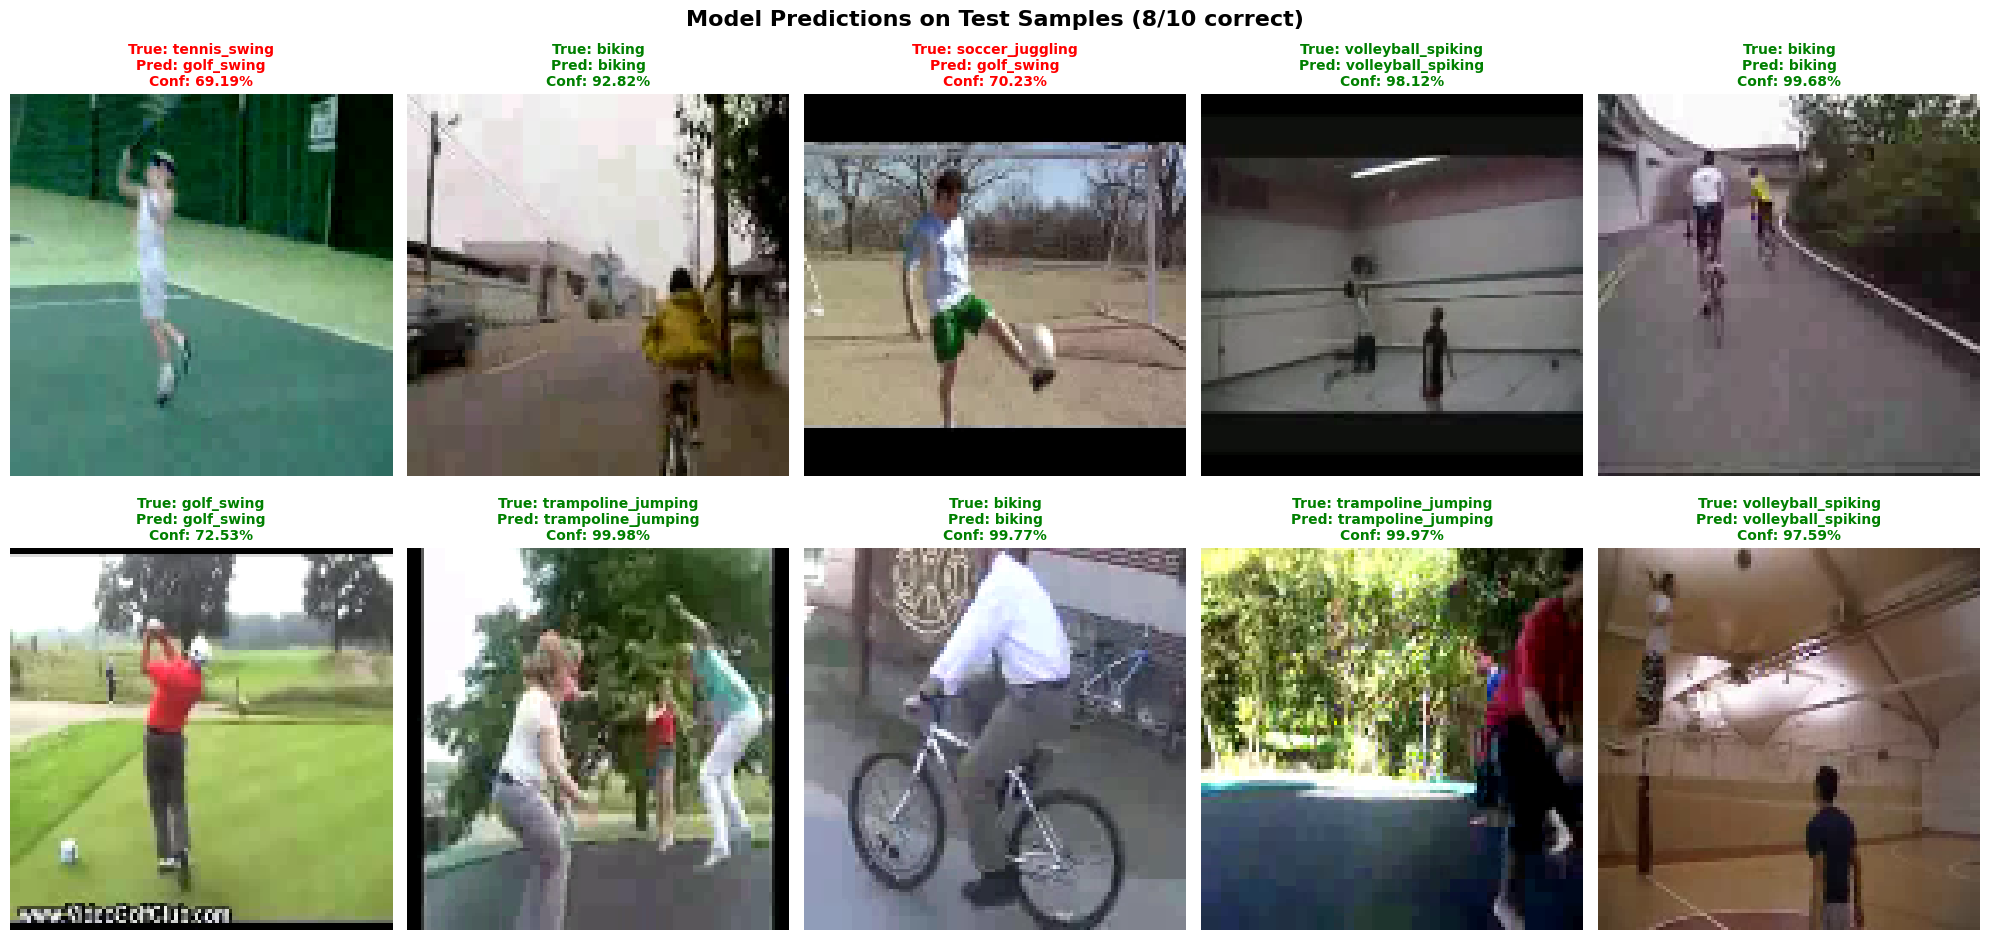


📊 Detailed Prediction Results:
--------------------------------------------------------------------------------
❌ Sample 1: True=tennis_swing         | Pred=golf_swing           | Conf=69.19%
✅ Sample 2: True=biking               | Pred=biking               | Conf=92.82%
❌ Sample 3: True=soccer_juggling      | Pred=golf_swing           | Conf=70.23%
✅ Sample 4: True=volleyball_spiking   | Pred=volleyball_spiking   | Conf=98.12%
✅ Sample 5: True=biking               | Pred=biking               | Conf=99.68%
✅ Sample 6: True=golf_swing           | Pred=golf_swing           | Conf=72.53%
✅ Sample 7: True=trampoline_jumping   | Pred=trampoline_jumping   | Conf=99.98%
✅ Sample 8: True=biking               | Pred=biking               | Conf=99.77%
✅ Sample 9: True=trampoline_jumping   | Pred=trampoline_jumping   | Conf=99.97%
✅ Sample 10: True=volleyball_spiking   | Pred=volleyball_spiking   | Conf=97.59%

📈 Sample Accuracy: 8/10 (80.0%)


In [17]:
# ============================================
# CELL 17: Test on Random Sample Videos with Visualization
# ============================================

def predict_and_visualize(model, X_data, Y_data, class_names, num_samples=10):
    """
    Test model on random samples and visualize predictions with confidence.
    """
    indices = random.sample(range(len(X_data)), min(num_samples, len(X_data)))
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    correct = 0
    results = []
    
    for i, idx in enumerate(indices):
        video = X_data[idx]
        true_label = Y_data[idx]
        
        # Predict
        pred_probs = model.predict(video[np.newaxis, ...], verbose=0)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]
        
        # Check if correct
        is_correct = pred_label == true_label
        if is_correct:
            correct += 1
        
        # Store result
        results.append({
            'true': class_names[true_label],
            'predicted': class_names[pred_label],
            'confidence': confidence,
            'correct': is_correct
        })
        
        # Display middle frame
        middle_frame = video[len(video)//2]
        axes[i].imshow(middle_frame)
        
        # Color based on correctness
        color = 'green' if is_correct else 'red'
        title = f"True: {class_names[true_label]}\n"
        title += f"Pred: {class_names[pred_label]}\n"
        title += f"Conf: {confidence:.2%}"
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle(f"Model Predictions on Test Samples ({correct}/{num_samples} correct)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print detailed results
    print("\n📊 Detailed Prediction Results:")
    print("-" * 80)
    for i, r in enumerate(results):
        status = "✅" if r['correct'] else "❌"
        print(f"{status} Sample {i+1}: True={r['true']:20s} | Pred={r['predicted']:20s} | Conf={r['confidence']:.2%}")
    
    print(f"\n📈 Sample Accuracy: {correct}/{num_samples} ({correct/num_samples:.1%})")
    
    return results

# Run predictions on test set
print("=" * 70)
print("🧪 TESTING ON RANDOM SAMPLES FROM TEST SET")
print("=" * 70)
prediction_results = predict_and_visualize(best_model, X_test, Y_test, class_names, num_samples=10)

🔍 ANALYZING MISCLASSIFICATIONS
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step

⚠️ Total Misclassifications: 33/165 (20.0%)


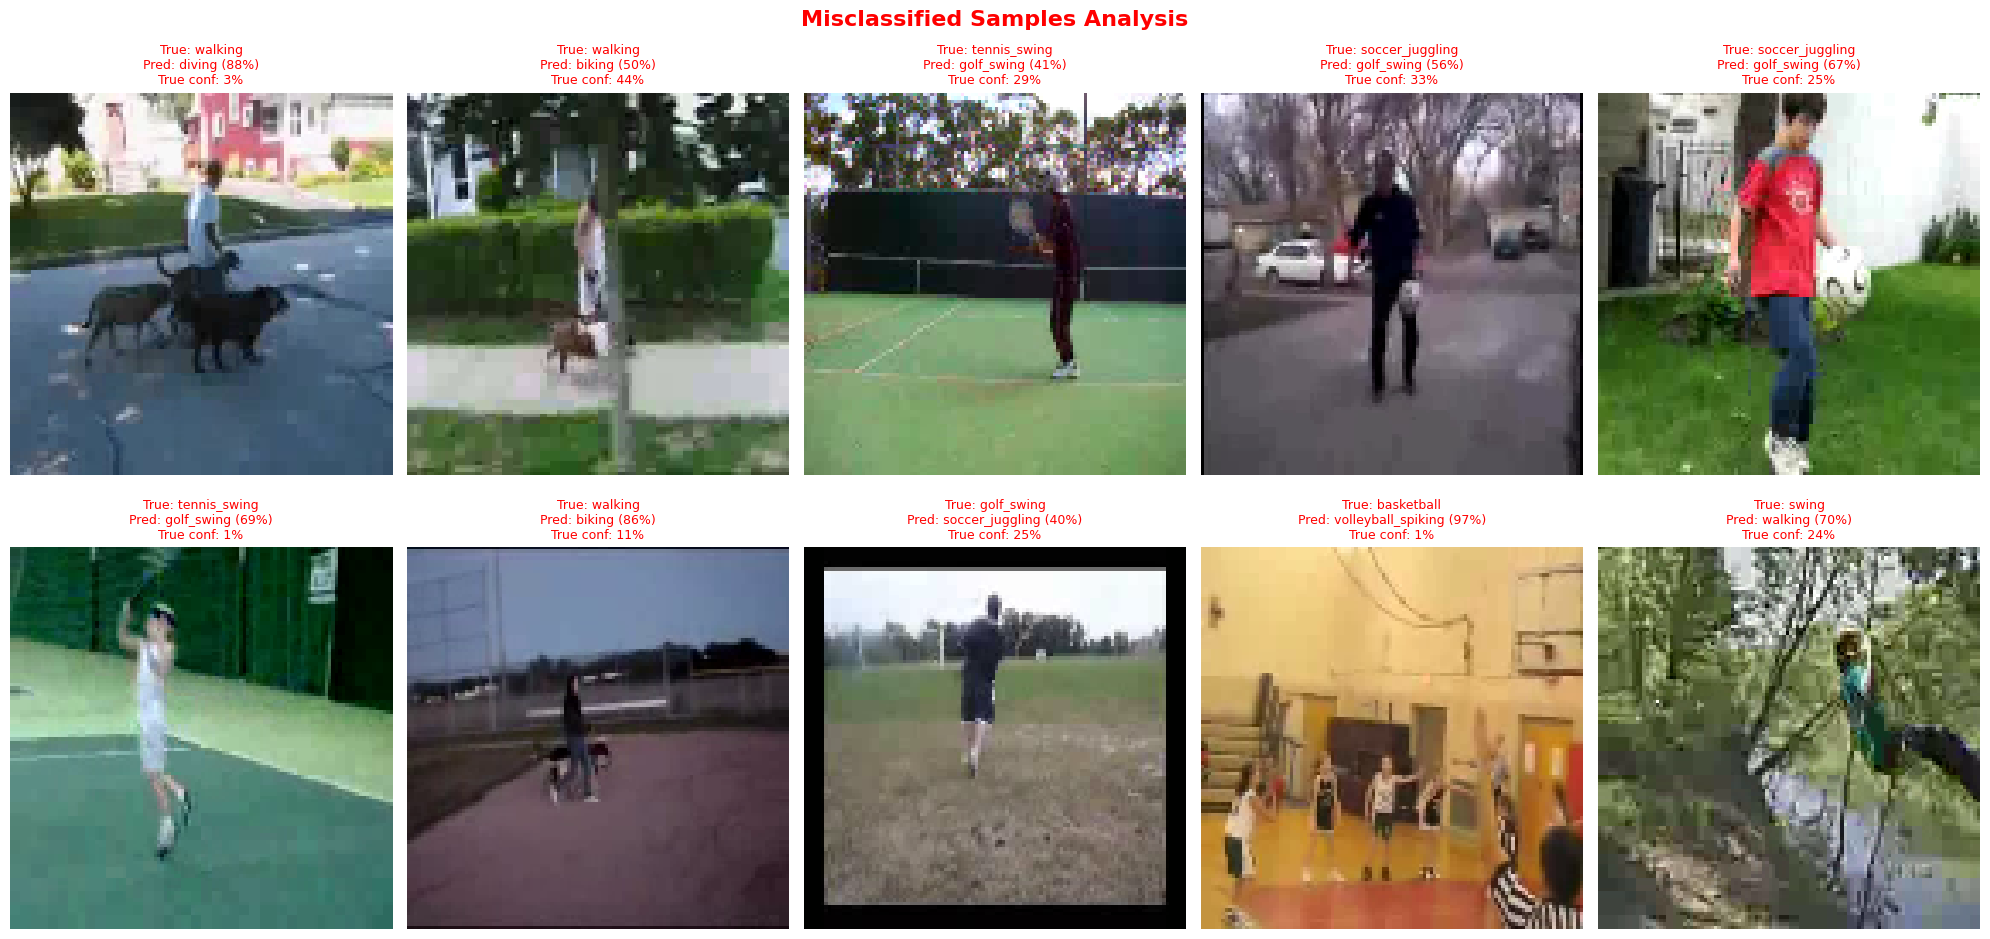


📊 Misclassification Patterns:
----------------------------------------------------------------------
   walking              → diving               (pred: 88%, true: 3%)
   walking              → biking               (pred: 50%, true: 44%)
   tennis_swing         → golf_swing           (pred: 41%, true: 29%)
   soccer_juggling      → golf_swing           (pred: 56%, true: 33%)
   soccer_juggling      → golf_swing           (pred: 67%, true: 25%)
   tennis_swing         → golf_swing           (pred: 69%, true: 1%)
   walking              → biking               (pred: 86%, true: 11%)
   golf_swing           → soccer_juggling      (pred: 40%, true: 25%)
   basketball           → volleyball_spiking   (pred: 97%, true: 1%)
   swing                → walking              (pred: 70%, true: 24%)


In [18]:
# ============================================
# CELL 18: Visualize Misclassified Samples
# ============================================

def visualize_misclassifications(model, X_data, Y_data, class_names, num_samples=10):
    """
    Find and visualize misclassified samples to understand model weaknesses.
    """
    # Get all predictions
    Y_pred_all = np.argmax(model.predict(X_data, verbose=1), axis=1)
    
    # Find misclassified indices
    misclassified_idx = np.where(Y_pred_all != Y_data)[0]
    
    if len(misclassified_idx) == 0:
        print("🎉 No misclassifications found!")
        return
    
    print(f"\n⚠️ Total Misclassifications: {len(misclassified_idx)}/{len(Y_data)} ({len(misclassified_idx)/len(Y_data):.1%})")
    
    # Sample misclassifications
    sample_idx = random.sample(list(misclassified_idx), min(num_samples, len(misclassified_idx)))
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    misclass_details = []
    
    for i, idx in enumerate(sample_idx):
        video = X_data[idx]
        true_label = Y_data[idx]
        
        pred_probs = model.predict(video[np.newaxis, ...], verbose=0)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]
        true_prob = pred_probs[true_label]
        
        misclass_details.append({
            'true': class_names[true_label],
            'predicted': class_names[pred_label],
            'pred_conf': confidence,
            'true_conf': true_prob
        })
        
        # Display middle frame
        middle_frame = video[len(video)//2]
        axes[i].imshow(middle_frame)
        
        title = f"True: {class_names[true_label]}\n"
        title += f"Pred: {class_names[pred_label]} ({confidence:.0%})\n"
        title += f"True conf: {true_prob:.0%}"
        axes[i].set_title(title, fontsize=9, color='red')
        axes[i].axis('off')
    
    plt.suptitle("Misclassified Samples Analysis", fontsize=16, fontweight='bold', color='red')
    plt.tight_layout()
    plt.savefig('/kaggle/working/misclassifications.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analyze confusion patterns
    print("\n📊 Misclassification Patterns:")
    print("-" * 70)
    for d in misclass_details:
        print(f"   {d['true']:20s} → {d['predicted']:20s} (pred: {d['pred_conf']:.0%}, true: {d['true_conf']:.0%})")
    
    return misclass_details

# Visualize misclassifications
print("=" * 70)
print("🔍 ANALYZING MISCLASSIFICATIONS")
print("=" * 70)
misclass_results = visualize_misclassifications(best_model, X_test, Y_test, class_names)

🎬 ACTION RECOGNITION DEMO - SAMPLE IMAGES WITH ANNOTATIONS

--- Demo Video 1 ---
   True Action: biking
   Predicted Action: biking (99.7%)


/tmp/ipykernel_55/933406809.py:69: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/933406809.py:72: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


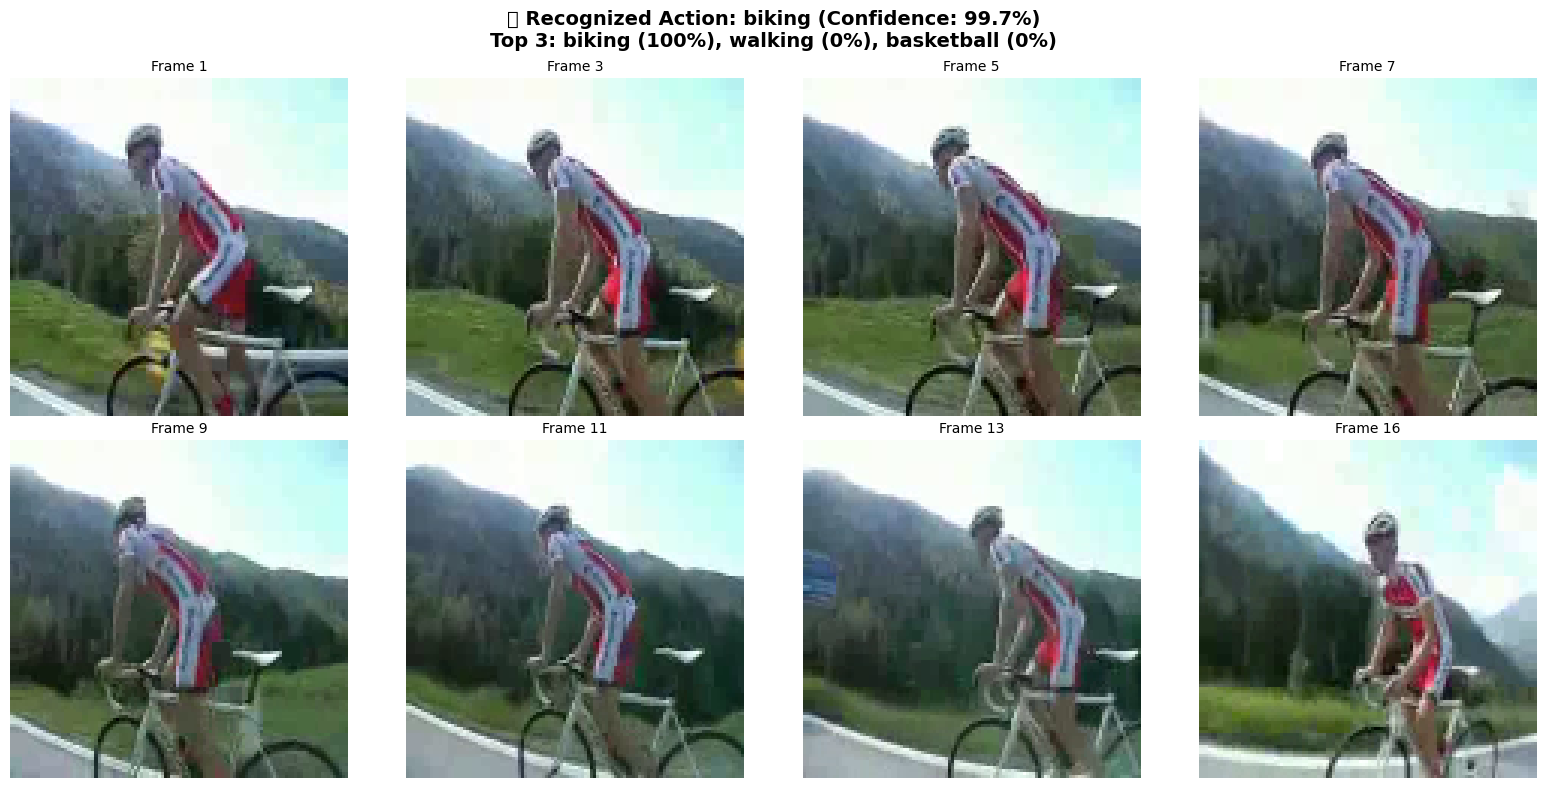


--- Demo Video 2 ---
   True Action: soccer_juggling
   Predicted Action: golf_swing (67.2%)


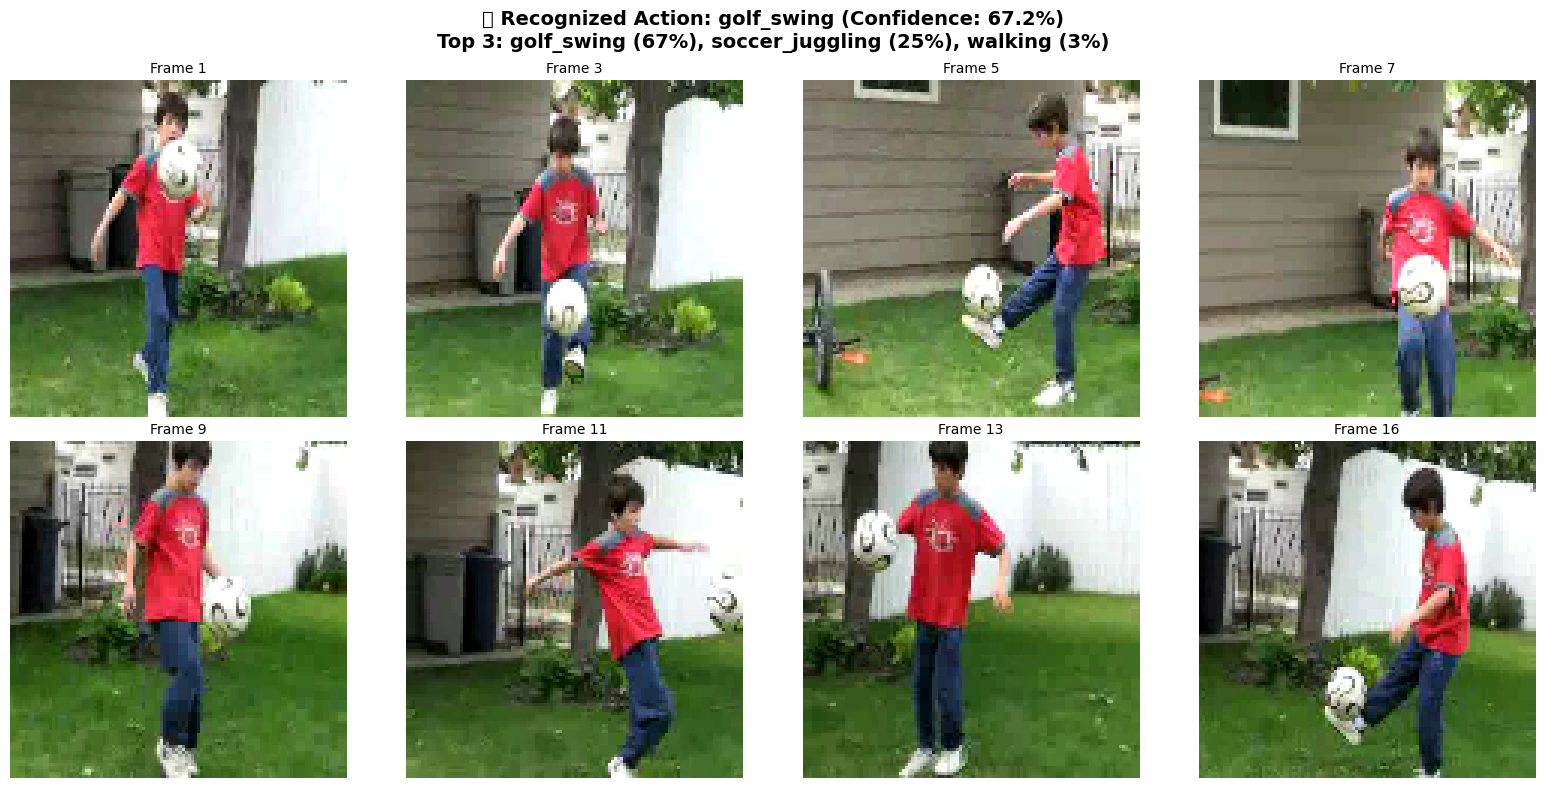


--- Demo Video 3 ---
   True Action: volleyball_spiking
   Predicted Action: volleyball_spiking (98.1%)


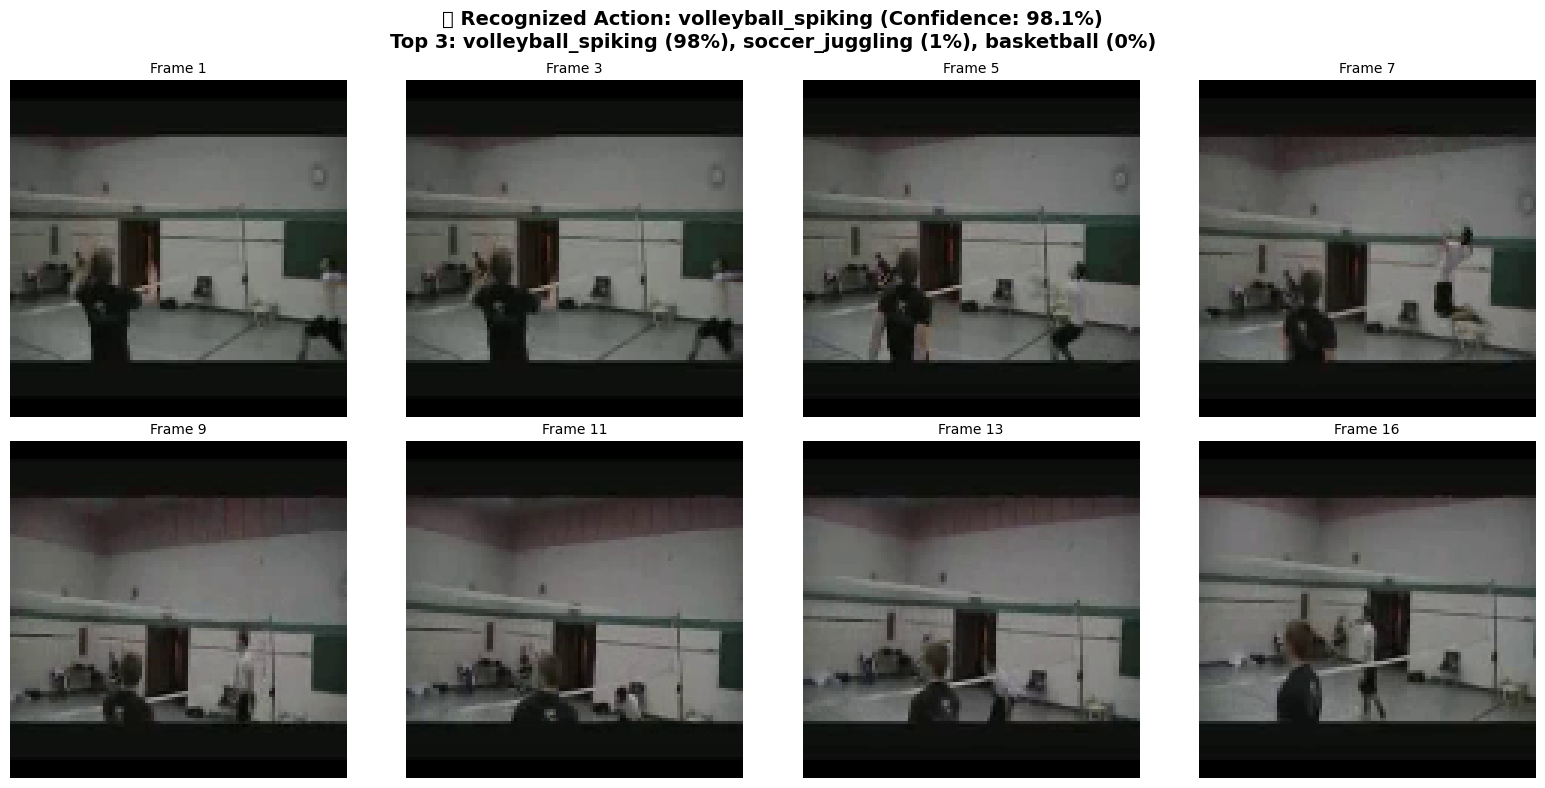


--- Demo Video 4 ---
   True Action: tennis_swing
   Predicted Action: tennis_swing (88.3%)


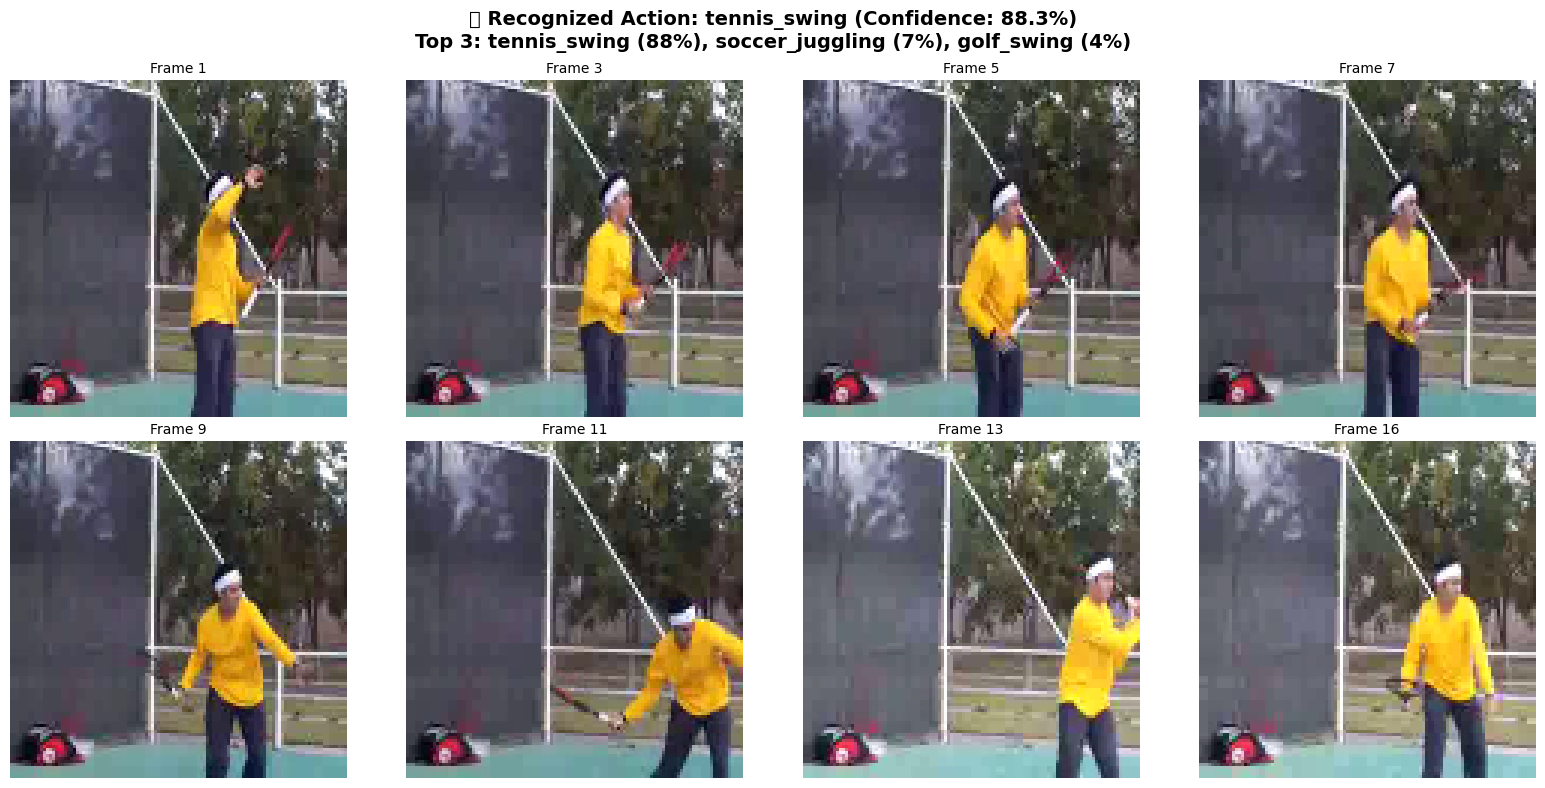


--- Demo Video 5 ---
   True Action: horse_riding
   Predicted Action: horse_riding (98.5%)


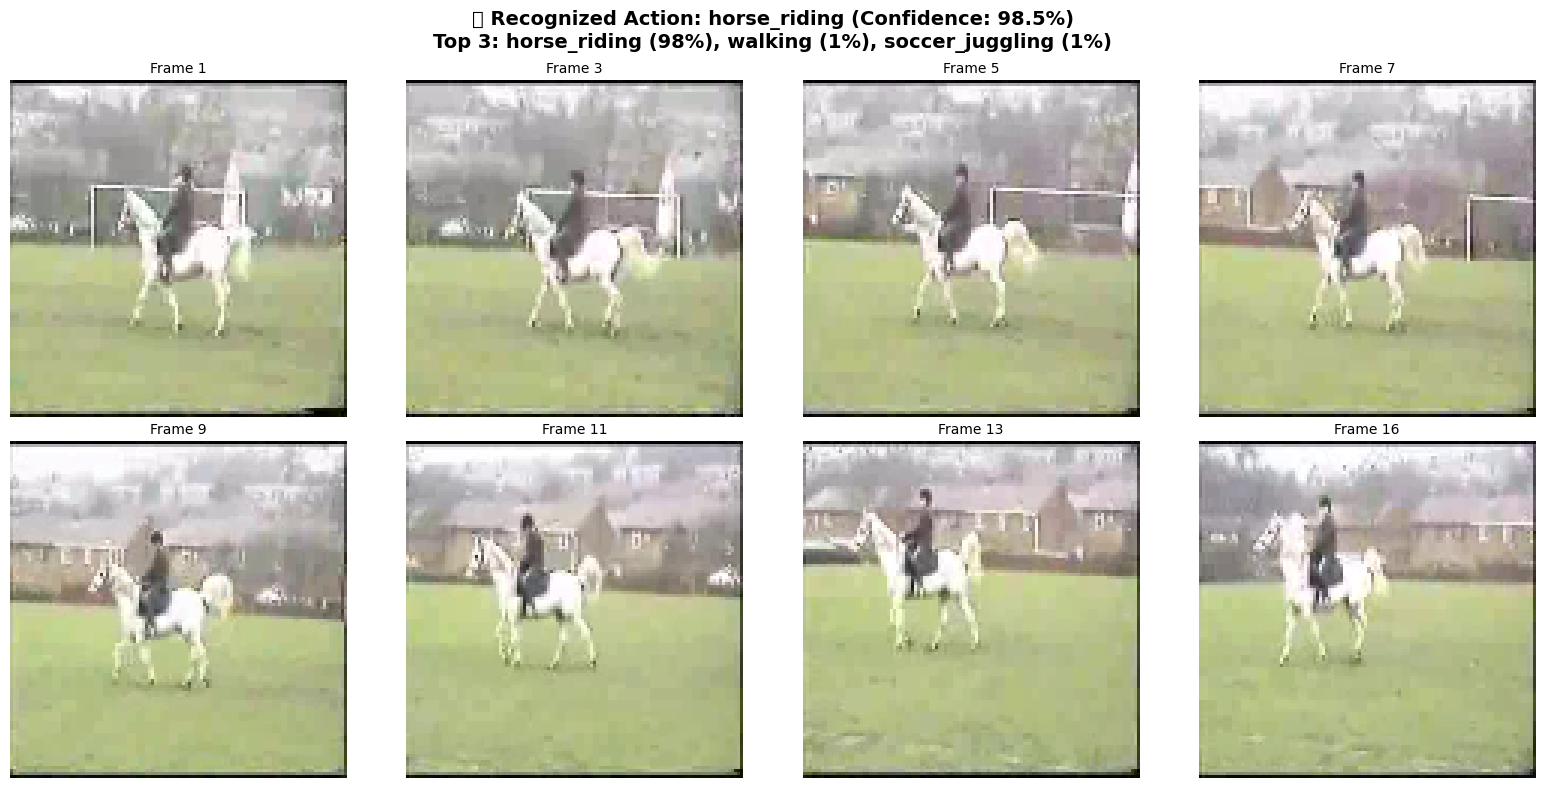

In [19]:
# ============================================
# CELL 19: Action Recognition on Sample Images (with Annotation)
# ============================================

def recognize_action_in_video(model, video_path, class_names, num_frames=16, frame_size=(112, 112)):
    """
    Perform action recognition on a new video and annotate frames.
    """
    # Extract frames
    frames = extract_frames_uniform(video_path, num_frames, frame_size)
    
    if frames is None:
        print(f"❌ Could not process video: {video_path}")
        return None, None
    
    # Normalize
    frames_normalized = frames / 255.0
    
    # Predict
    pred_probs = model.predict(frames_normalized[np.newaxis, ...], verbose=0)[0]
    pred_label = np.argmax(pred_probs)
    confidence = pred_probs[pred_label]
    action_name = class_names[pred_label]
    
    # Get top 3 predictions
    top3_idx = np.argsort(pred_probs)[-3:][::-1]
    top3_predictions = [(class_names[i], pred_probs[i]) for i in top3_idx]
    
    return {
        'action': action_name,
        'confidence': confidence,
        'top3': top3_predictions,
        'frames': frames
    }


def annotate_and_display_action(result, save_path=None):
    """
    Display annotated frames showing recognized action.
    """
    if result is None:
        return
    
    frames = result['frames']
    action = result['action']
    confidence = result['confidence']
    top3 = result['top3']
    
    # Display 8 sample frames with annotations
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    frame_indices = np.linspace(0, len(frames)-1, 8, dtype=int)
    
    for i, idx in enumerate(frame_indices):
        frame = frames[idx].astype(np.uint8)
        
        # Add text annotation to frame
        annotated = frame.copy()
        
        axes[i].imshow(annotated)
        axes[i].set_title(f"Frame {idx+1}", fontsize=10)
        axes[i].axis('off')
    
    # Add overall title with prediction
    title = f"🎬 Recognized Action: {action} (Confidence: {confidence:.1%})\n"
    title += f"Top 3: {top3[0][0]} ({top3[0][1]:.0%}), {top3[1][0]} ({top3[1][1]:.0%}), {top3[2][0]} ({top3[2][1]:.0%})"
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return annotated


# Demo: Recognize actions in sample videos from test set
print("=" * 70)
print("🎬 ACTION RECOGNITION DEMO - SAMPLE IMAGES WITH ANNOTATIONS")
print("=" * 70)

# Pick 5 random test samples to demonstrate action recognition
demo_indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(demo_indices):
    print(f"\n--- Demo Video {i+1} ---")
    
    # Simulate having a "video" (we'll use test data directly)
    video_frames = (X_test[idx] * 255).astype(np.float32)  # De-normalize for display
    true_label = Y_test[idx]
    
    # Create result dict
    pred_probs = best_model.predict(X_test[idx:idx+1], verbose=0)[0]
    pred_label = np.argmax(pred_probs)
    confidence = pred_probs[pred_label]
    
    top3_idx = np.argsort(pred_probs)[-3:][::-1]
    top3 = [(class_names[j], pred_probs[j]) for j in top3_idx]
    
    result = {
        'action': class_names[pred_label],
        'confidence': confidence,
        'top3': top3,
        'frames': (X_test[idx] * 255).astype(np.uint8)
    }
    
    print(f"   True Action: {class_names[true_label]}")
    print(f"   Predicted Action: {result['action']} ({result['confidence']:.1%})")
    
    annotate_and_display_action(result, save_path=f'/kaggle/working/demo_action_{i+1}.png')

In [20]:
# ============================================
# CELL 20: Download Best Model
# ============================================

import shutil

print("=" * 70)
print("📦 MODEL DOWNLOAD PREPARATION")
print("=" * 70)

# Verify best model exists
if os.path.exists(config.MODEL_SAVE_PATH):
    model_size = os.path.getsize(config.MODEL_SAVE_PATH) / (1024 * 1024)
    print(f"✅ Best model saved at: {config.MODEL_SAVE_PATH}")
    print(f"   Model size: {model_size:.2f} MB")
    
    # Also save as H5 format for compatibility
    h5_path = config.MODEL_SAVE_PATH.replace('.keras', '.h5')
    best_model.save(h5_path)
    h5_size = os.path.getsize(h5_path) / (1024 * 1024)
    print(f"✅ Also saved as H5: {h5_path}")
    print(f"   H5 size: {h5_size:.2f} MB")
else:
    print("❌ Model file not found!")

# Save model architecture as JSON
model_json = best_model.to_json()
json_path = '/kaggle/working/model_architecture.json'
with open(json_path, 'w') as f:
    f.write(model_json)
print(f"✅ Architecture saved: {json_path}")

# Save class names mapping
class_mapping_path = '/kaggle/working/class_names.txt'
with open(class_mapping_path, 'w') as f:
    for i, name in enumerate(class_names):
        f.write(f"{i}: {name}\n")
print(f"✅ Class mapping saved: {class_mapping_path}")

# List all saved files
print("\n📁 All saved files in /kaggle/working/:")
for f in sorted(os.listdir('/kaggle/working')):
    fpath = os.path.join('/kaggle/working', f)
    if os.path.isfile(fpath):
        size = os.path.getsize(fpath) / 1024
        print(f"   {f:40s} - {size:.1f} KB")

print("\n" + "=" * 70)
print("💾 TO DOWNLOAD THE BEST MODEL:")
print("=" * 70)
print("1. Click on the 'Output' tab in Kaggle (right side panel)")
print("2. Find 'best_action_recognition_model.keras' or '.h5'")
print("3. Click the download icon (↓) next to the file")
print("=" * 70)

📦 MODEL DOWNLOAD PREPARATION
✅ Best model saved at: /kaggle/working/best_action_recognition_model.keras
   Model size: 41.93 MB
✅ Also saved as H5: /kaggle/working/best_action_recognition_model.h5
   H5 size: 41.71 MB
✅ Architecture saved: /kaggle/working/model_architecture.json
✅ Class mapping saved: /kaggle/working/class_names.txt

📁 All saved files in /kaggle/working/:
   best_action_recognition_model.h5         - 42714.5 KB
   best_action_recognition_model.keras      - 42931.6 KB
   class_names.txt                          - 0.2 KB
   classification_report.txt                - 1.0 KB
   confusion_matrix.png                     - 115.5 KB
   confusion_matrix_normalized.png          - 147.4 KB
   demo_action_1.png                        - 302.4 KB
   demo_action_2.png                        - 340.9 KB
   demo_action_3.png                        - 214.3 KB
   demo_action_4.png                        - 302.0 KB
   demo_action_5.png                        - 276.7 KB
   metrics_compariso

In [21]:
# ============================================
# CELL 21: Final Summary Report
# ============================================

print("=" * 80)
print("                    📊 FINAL MODEL EVALUATION SUMMARY 📊")
print("=" * 80)

print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                              DATASET INFORMATION                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  Dataset:           UCF11 Action Recognition                                │
│  Total Classes:     {num_classes:3d}                                                   │
│  Total Samples:     {len(X):5d}                                                 │
│  Frame Resolution:  {config.FRAME_HEIGHT}x{config.FRAME_WIDTH}                                               │
│  Frames per Video:  {config.NUM_FRAMES:3d}                                                   │
├─────────────────────────────────────────────────────────────────────────────┤
│                              DATA SPLIT                                     │
├─────────────────────────────────────────────────────────────────────────────┤
│  Training:          {len(X_train):5d} samples ({len(X_train)/len(X)*100:.1f}%)                               │
│  Validation:        {len(X_val):5d} samples ({len(X_val)/len(X)*100:.1f}%)                               │
│  Test:              {len(X_test):5d} samples ({len(X_test)/len(X)*100:.1f}%)                               │
├─────────────────────────────────────────────────────────────────────────────┤
│                              MODEL PERFORMANCE                              │
├─────────────────────────────────────────────────────────────────────────────┤
│  Training Accuracy:     {train_acc:.4f} ({train_acc*100:.2f}%)                              │
│  Validation Accuracy:   {val_acc:.4f} ({val_acc*100:.2f}%)                              │
│  Test Accuracy:         {test_acc:.4f} ({test_acc*100:.2f}%)                              │
│  ───────────────────────────────────────────────────────────────────────    │
│  Training Loss:         {train_loss:.4f}                                         │
│  Validation Loss:       {val_loss:.4f}                                         │
│  Test Loss:             {test_loss:.4f}                                         │
│  ───────────────────────────────────────────────────────────────────────    │
│  Precision (Weighted):  {precision_weighted:.4f}                                         │
│  Recall (Weighted):     {recall_weighted:.4f}                                         │
│  F1-Score (Weighted):   {f1_weighted:.4f}                                         │
├─────────────────────────────────────────────────────────────────────────────┤
│                              GENERALIZATION CHECK                           │
├─────────────────────────────────────────────────────────────────────────────┤
│  Train-Val Gap:         {abs(train_acc - val_acc):.4f} {'✅ Good' if abs(train_acc - val_acc) < 0.15 else '⚠️  Monitor'}                               │
│  Train-Test Gap:        {abs(train_acc - test_acc):.4f} {'✅ Good' if abs(train_acc - test_acc) < 0.15 else '⚠️  Monitor'}                               │
├─────────────────────────────────────────────────────────────────────────────┤
│                              FILES SAVED                                    │
├─────────────────────────────────────────────────────────────────────────────┤
│  ✅ best_action_recognition_model.keras                                     │
│  ✅ best_action_recognition_model.h5                                        │
│  ✅ model_architecture.json                                                 │
│  ✅ class_names.txt                                                         │
│  ✅ confusion_matrix.png                                                    │
│  ✅ training_history.png                                                    │
│  ✅ per_class_accuracy.png                                                  │
│  ✅ classification_report.txt                                               │
└─────────────────────────────────────────────────────────────────────────────┘
""")

print("=" * 80)
print("                         ✅ NOTEBOOK COMPLETED SUCCESSFULLY!")
print("=" * 80)

                    📊 FINAL MODEL EVALUATION SUMMARY 📊

┌─────────────────────────────────────────────────────────────────────────────┐
│                              DATASET INFORMATION                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  Dataset:           UCF11 Action Recognition                                │
│  Total Classes:      11                                                   │
│  Total Samples:      1100                                                 │
│  Frame Resolution:  112x112                                               │
│  Frames per Video:   16                                                   │
├─────────────────────────────────────────────────────────────────────────────┤
│                              DATA SPLIT                                     │
├─────────────────────────────────────────────────────────────────────────────┤
│  Training:            770 samples (70.0%)                             